In [59]:
import numpy as np
import scipy.stats as sps
from time import time 
from math import *
import matplotlib.pyplot as plt

# I. Discretisation Scheme for the Black-Scholes model

### 1. Black-Scholes Model

In the Black-Scholes model, for a one dimension environment, the dynamics of a financial assets $X_{t}$ is the solution of:

$$d X_{t}=r X_{t}dt+X_{t} \sigma dW_{t} \quad, \quad X_{0} \in \mathbb{R} \quad t \in [0,T] $$

where, $W_{t}$ is a Brownian Motion. 

#### Explicit solution

$$X_t = X_0 e^{(r-\frac{\sigma^2}{2}) t + \sigma W_t}
$$

In [60]:
def BS_Explicit(x,DW,r,sigma,T,m):
    dt=T/m
    DX = np.exp((r-sigma**2/2)*dt + sigma*DW)
    X = np.c_[np.zeros(len(DW[:,0]))+x, x*np.cumprod(DX,axis=1)]
    return(X)

### 2. Euler Scheme


The Euler discretisation for $m$ steps $\hat{X}^{m}$ of $X$ is thus constructed by setting $\hat{X}_{0}^{m}=x$ and then recursively for $0 \leq i \leq m-1$ :

$$
\hat{X}_{t_{i+1}}^{m}=\hat{X}_{t_{i}}^{m}+r\hat{X}_{t_{i}}^{m} \Delta t+\sigma\hat{X}_{t_{i}}^{m} \Delta W_{i}
$$

where $\Delta W_{i}:=W_{t_{i+1}}-W_{t_{i}}$, and $\Delta t = t_{i+1} - t_{i}=\frac{T}{m} $

which can be written as:

$$\hat{X}_{t_{i+1}}^{m}=\hat{X}_{t_{i}}^{m} \left( 1+r \Delta t+ \sigma \Delta W_{i} \right) $$



In [61]:
def BS_Euler_Scheme(x,DW,r,sigma,T,m):
        dt=T/m
        Xbar_Euler=np.zeros(DW.shape)
        Xbar_Euler=np.c_[x+np.zeros(len(DW[:,0])),Xbar_Euler]
        for i in range(m):
            Xbar_Euler[:,i+1] = Xbar_Euler[:,i]*(1+r*dt+sigma*DW[:,i])
        return(Xbar_Euler)   

### 3. Milstein Scheme

The Milstein discretisation adds the correction term $\frac{1}{2} \sigma^{2} \left(\Delta W_{i}^{2}-\Delta t\right)$ to the Euler scheme :

$$
\hat{X}_{t_{i+1}}^{m}=\hat{X}_{t_{i}}^{m}+r\hat{X}_{t_{i}}^{m} \Delta t+\sigma\hat{X}_{t_{i}}^{m} \Delta W_{i} + \frac{\sigma^{2}}{2}  \hat{X}_{t_{i}}^{m}\left(\Delta W_{i}^{2}-\Delta t\right) 
$$

which can be written as:

$$\hat{X}_{t_{i+1}}^{m}=\hat{X}_{t_{i}}^{m} \left( 1+r \Delta t+ \sigma \Delta W_{i} + \frac{\sigma^{2}}{2}  \left(\Delta W_{i}^{2}-\Delta t\right) \right) $$


In [62]:
def BS_Milstein_Scheme(x,DW,r,sigma,T,m):
        h=T/m
        Xbar_Milstein=np.zeros(DW.shape)
        Xbar_Milstein=np.c_[x+np.zeros(len(DW[:,0])),Xbar_Milstein]
        for i in range(m):
            Xbar_Milstein[:,i+1] = Xbar_Milstein[:,i]*(1+r*h+sigma*DW[:,i]+0.5*(sigma**2)*(DW[:,i]**2-h))
        return(Xbar_Milstein)

#### Strong Error


Strong error = $\mathbb{E}\left[\sup _{t \in[0, T]}\left|X_{t}-\hat{X}_{t}^{m}\right|^{2}\right]^{\frac{1}{2}}$

In [63]:
def Strong_Error(Xbar,X):
    return np.sqrt(np.mean(np.max((X-Xbar)**2,axis=1)))

### 4. Strong Error : Euler and Milstein discretisation 

**Here we will illustrate briefly how the Milstein Scheme differs in terms of strong error convergence.

### Parameters 

Parameters as in "Multilevel Monte Carlo Path Simulation" M.B.Giles (2008)

$ r = 5%$,
$ \sigma = 0.2 ,  $
$ X_0=x=0.05 , $
$ T=1 , $

In [64]:
r,sigma,x,T=0.05,0.2,1,1
n=10**4 #Samples
k=6

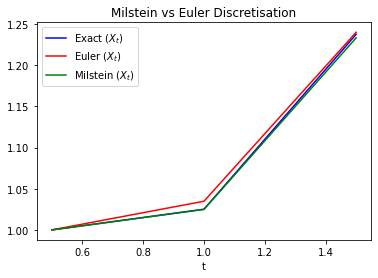

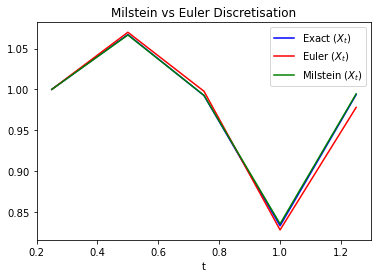

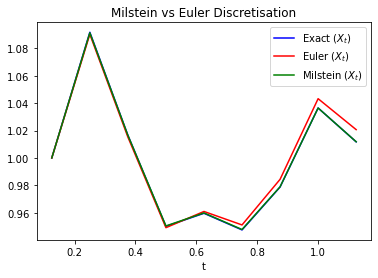

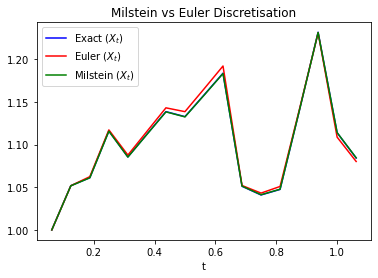

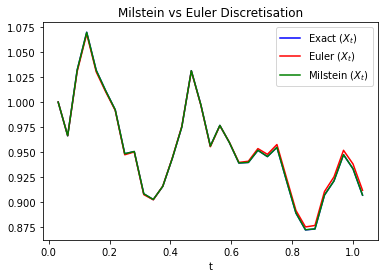

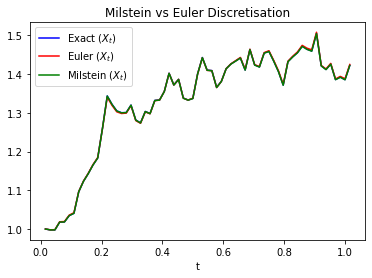

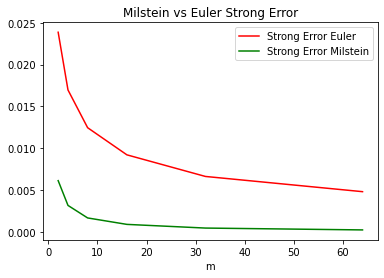

In [7]:
Strong_Error_Euler=np.zeros(k)
Strong_Error_Milstein=np.zeros(k)

for j in range(k):
    m=2**(j+1) #Steps 
    dt=T/m
    
    DW = np.random.randn(n,m)*np.sqrt(dt)
    X=BS_Explicit(x,DW,r,sigma,T,m)
    Xbar_Euler=BS_Euler_Scheme(x,DW,r,sigma,T,m)
    Xbar_Milstein=BS_Milstein_Scheme(x,DW,r,sigma,T,m)
    
    Strong_Error_Euler[j]=Strong_Error(Xbar_Euler,X)
    Strong_Error_Milstein[j]=Strong_Error(Xbar_Milstein,X)

    t = np.arange(dt, T + 2*dt, dt)
    plt.plot(t,X[0,:],label="Exact ($X_t$)",color="blue")    
    plt.plot(t,Xbar_Euler[0,:],label="Euler ($X_t$)",color="red")
    plt.plot(t,Xbar_Milstein[0,:],label="Milstein ($X_t$)",color="green")
    plt.xlabel("t")
    plt.legend(loc=0)
    plt.title("Milstein vs Euler Discretisation")
    plt.show()
    
h=2**np.arange(1,k+1)
plt.plot(h,Strong_Error_Euler,label="Strong Error Euler",color="red")
plt.plot(h,Strong_Error_Milstein,label="Strong Error Milstein",color="green")
plt.legend(loc=0)
plt.xlabel("m")
plt.title("Milstein vs Euler Strong Error")
plt.show()

# II. Classic Monte Carlo

### 1. Classic Monte Carlo estimator

We are interested in pricing a financial product such as an option. The price of such a product is $\mathbb{E}\left[P(X_0,...,X_T)\right]$ where $P$ is a function we call payoff. 
The classic Monte Carlo estimator $\hat Y_{n}$ of $\mathbb{E}\left[P(X_0,...,X_T)\right]$ for a sample of size $n$:

$$\hat Y_{n}= \frac{1}{n}\sum_{i=1}^{n} P(X^{i}_0,...,X^{i}_T)$$

where, $X^{i}_0,...,X^{i}_T$ are independent and identically distributed of same law as $X_0,...,X_T$

Now, if we use a discretisation $\hat X^{m}_t$ for $X_t$, we denote the estimator $\hat Y^{m}_{n}$


### 2. Mean Square Error without discretisation

The mean square error is defined as: 

$$ MSE =  \mathbb{E}\left[ ( \hat Y_{n} -  \mathbb{E}\left[P(X_0,...,X_T)\right] )  ^{2}\right]$$

The MSE can be decomposed as: 

$$ MSE = Var( \hat Y_{n} ) + (\mathbb{E}\left[\hat Y_{n}\right] -  \mathbb{E}\left[P(X_0,...,X_T)\right]) ^{2}$$

$$ MSE  = \frac{Var( P(X_0,...,X_T) )}{n} $$ 
as $$(\mathbb{E}\left[\hat Y_{n}\right] -  \mathbb{E}\left[P(X_0,...,X_T)\right]) ^{2} = 0 $$

Let's say we want an $MSE\approx \epsilon^{2}$, then we will need $n\approx \frac{Var( P(X_0,...,X_T)) }{\epsilon^{-2}}$

However, usually $Var(P(X_0,...,X_T))$ is not known. Therefore, we will use a pre-routine estimation. This will be useful when we will compare the Multilevel Monte Carlo to the classic Monte Carlo method, as we will need to have estimators of rougthly same quality. 

In [65]:
def pre_routine_Var(N,M,Payoff,BS_Scheme,r,sigma,T,K):
    dt=T/M
    DW=np.random.randn(N,M)*np.sqrt(dt)
    Xbar=BS_Scheme(x,DW,r,sigma,T,M)
    return(np.var(Payoff(Xbar,K,T,r)))

### 3. Mean Square Error with discretisation

$$ MSE  = \frac{Var( P(X_0,...,X_T) )}{n} + (\mathbb{E}[\hat Y^{m}_{n}] -  \mathbb{E}\left[P(X_0,...,X_T)\right]) ^{2}$$

$$ MSE  = \frac{Var( P(X_0,...,X_T) )}{n} + (\mathbb{E}[P(\hat X^{m}_0,...,\hat X^{m}_T)] -  \mathbb{E}\left[P(X_0,...,X_T)\right]) ^{2}$$

Here, $\mathbb{E}[P(\hat X^{m}_0,...,\hat X^{m}_T)] -  \mathbb{E}\left[P(X_0,...,X_T)\right]$ is the Weak Error introduced by the discretisation.

Under the conditions of Theorem 3.5. of "Monte Carlo and Finite Difference Methods with Applications in Finance"
J. Claisse (2020), we have: 

$$\mathbb{E}[P(\hat X^{m}_0,...,\hat X^{m}_T)] -  \mathbb{E}[P(X_0,...,X_T)]=O(m^{-1})$$

Therefore, to achieve $MSE\approx \epsilon^{2}$, we choose $n\approx \frac{2Var( P(X_0,...,X_T)) }{\epsilon^{2}}$ and $m \approx  \sqrt{n}$

#### Computational Cost

We define the computational cost as $ nm  \approx \epsilon^{-3}$ 


In [66]:
def MC(eps,x,BS_Scheme,Payoff,var,r,sigma,T,K): #var is estimated by pre_routine_Var
    N=np.ceil(2*var/(eps**2))
    M=np.ceil(np.sqrt(N))
    h=T/M
    DW=np.random.randn(int(N),int(M))*np.sqrt(h)
    Xbar=BS_Scheme(x,DW,r,sigma,T,int(M))
    P=np.mean(Payoff(Xbar,K,T,r))
    s=np.std(Payoff(Xbar,K,T,r))
    cost=N*M
    
    print("Estimator=",P)    
    print("Condidence interval 95%:",[P-1.96*s/np.sqrt(N),P+1.96*s/np.sqrt(N)])
    print("Error:",100*1.96*s/(P*np.sqrt(N)),"%","\n")
    print("Computational Cost=",cost)
    print("Number of samples=",N)
    print("Steps=",M)
    print("eps=",eps,"\n")

    return (P,N,M,s)

# III. Payoffs 

### 1. European Call Option

The price of a European call option with strike $K$ and maturity $T$ is given by:

$$
 \mathbb{E}\left[e^{-rT}(X_T-K)^+\right]
$$

$$Payoff_{European Call} =e^{-rT}(X_T-K)^+$$

In [67]:
def Payoff_Euro_Call(X,K,T,r):
    return(np.maximum(X[:,-1]-K,0)*np.exp(-r*T))

The exact price of the European Call option using the Black-Scholes formula is:
$$
 Call_{BS}=X_0 \mathcal{N}\left(d_1\right) - K e^{-rT} \mathcal{N}\left(d_1 - \sigma\sqrt{T}\right), \quad \text{with } d_1 = \frac{1}{\sigma \sqrt{T}} \left(\text{ln}\left(\frac{X_0}{K}\right) + \left(r+\frac{\sigma^2}{2}\right) T \right),
$$

** The exact price will be useful when we will compute the mean square error (MSE).

In [68]:
def Call_BS(r,sigma,x,K,T):
    d=(np.log(x/K)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))
    return x*sps.norm.cdf(d)-K*np.exp(-r*T)*sps.norm.cdf(d-sigma*np.sqrt(T)) # Exact price European Call BS 

### 2. Asian Option

The price of an Asian option with strike $K$ and maturity $T$ is given by:
$$
 \mathbb{E}\left[e^{-rT}(\bar{X_{T}}-K)^+\right]
$$

$$Payoff_{AsianOption}=e^{-rT} (\bar{X_{T}}-K)^+$$ 

where,
$\bar{X_{T}}=\int_{0}^{T} X(t) \mathrm{d} t$

The integrale is approximated by:
$$\bar X_{T}= \frac{T}{m}\sum_{i=1}^{m} \frac{X_{t_{i}}+{X}_{t_{i-1}}}{2}$$

Thus, for the discretised $\hat X^{m}$ we will have:
$$\bar{\hat X}^{m}_{T}= \frac{T}{m}\sum_{i=1}^{m} \frac{\hat{X}^{m}_{t_{i}}+\hat{X}^{m}_{t_{i-1}}}{2}$$


In [79]:
def Payoff_Asian_Option(X,K,T,r):
    A=(np.sum(X[:,1:]+X[:,:-1],axis=1))*0.5*(T/len(X[0,:]))
    return np.exp(-r*T)*np.maximum(A-K,0)

### 3. Lookback Option

The price of a Lookback option with maturity $T$ is given by:
$$
 \mathbb{E}\left[e^{-rT}(X_{T}-\min _{0<t<T} X_{t})\right]
$$


$$Payoff_{LookbackOption}=e^{-rT}(X_{T}-\min _{0<t<T} X_{t})$$

Thus, for the discretised $\hat X^{m}$ the minimum value of $X$ is approximated by:

$$\hat{X}^{m}_{\min }=\left(\min _{{0\leq i\leq m}} \hat{X}^{m}_{t_{i}}\right)\left(1-\beta^{*} \sigma \sqrt{ \frac{T}{m}}\right)$$

with $\beta^{*} ≈ 0.5826$

In [13]:
def Payoff_Lookback_Option(X,K,T,r):
    beta=0.5826
    Xmin=np.min(X,axis=1)
    return np.exp(-r*T)*(X[:,-1] - Xmin*(1-beta*sigma*np.sqrt(T/len(X[0,:]))))

### 4. Digital Option

The price of a Digital option with maturity $T$ is given by:
$$
 \mathbb{E}\left[e^{-rT} 1_{X_{T}\geq K}\right]
$$

$$Payoff_{DigitalOption}=e^{-rT} 1_{X_{T}\geq K}$$

$$Var(Payoff_{DigitalOption})=Var(e^{-rT} 1_{X_{T}\geq K})$$

$$=e^{-2rT} P(X_{T}\geq K)P(X_{T}< K)$$

$$=e^{-2r t} \mathcal{N}(d_2)(1-\mathcal{N}(d_2))$$

In [14]:
def Payoff_Digital_Option(X,K,T,r):
    return (X[:,-1]>=K)*1*np.exp(-r*T)

The exact price of the Digital option using the Black-Scholes formula is:
$$Digital_{BS}=-\frac{\partial Call_{BS}}{\partial K}$$
as  $$\frac{\partial Call_{BS}(K)}{\partial K}=\frac{\partial(X_0 \mathcal{N}\left(d_1\right) - K e^{-rT} \mathcal{N}\left(d_1 - \sigma\sqrt{T}\right))}{\partial K}$$

$$-\frac{\partial Call_{BS}(K)}{\partial K}=e^{-r t} \mathcal{N}(d_2)$$

where, $d_2=d_1 - \sigma\sqrt{T}$




In [15]:
def Digital_BS(r,sigma,x,K,T):
    d2=(np.log(x/K)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T))
    return(np.exp(-r*T)*sps.norm.cdf(d2))  # Exact price Digital Option

We can also price this option using the Finite Difference method:

$$Digital_{BS}(K)=-\frac{\partial Call_{BS}(K)}{\partial K}=\lim _{\delta \rightarrow 0} \frac{Call_{BS}(K-\delta)-Call_{BS}(K+\delta)}{2 \delta}$$

In [16]:
def Finite_Difference_Digital(r,sigma,x,K,T,delta):
    return (Call_BS(r,sigma,x,K-delta,T)-Call_BS(r,sigma,x,K+delta,T))/(2*delta)

### 5. Tests of the implemented functions

Here, we simply test our implementation and compare the results to those of M.B.Giles (2008) to see if they are logic.

We find that our implementation seems correct judging by the results we get below. 


### Parameters

Parameters as in "Multilevel Monte Carlo Path Simulation" M.B.Giles (2008)

$ r = 5%$,
$ \sigma = 0.2 ,  $
$ X_0=x=0.05 , $
$ K=1 , $
$ T=1 , $

In [69]:
r,sigma,x,K,T=0.05,0.2,1,1,1

### a. European Call

 $ value \approx 0.10 $



#### Explicit Scheme and Exact value

We can see that the function MC is well implemented as we get an $MSE$ of $\epsilon^{2}$.

**From $\epsilon = 10^{-4}$ and lower, sufficient RAM is necessary, we advise not getting below $\epsilon = 10^{-3}$**

In [19]:
#Exact Euro Call Value
BS_Call=Call_BS(r,sigma,x,K,T)
print("Exact Value Call_BS=", BS_Call,"\n")

eps=0.001

#Euro Call with Classic MC and Explicit solution of Black-Scholes SDE
Payoff=Payoff_Euro_Call
BS_Scheme=BS_Explicit

n=10**4 # For the pre-routine estimation of Var(P)
M=4
Var_Esti_Explicit=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)

EuroCall_Explicit,N_Explicit,M_Explicit,Var_Explicit=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Explicit,r,sigma,T,K)

MSE_Explicit_Euro_Call=Var_Explicit/N_Explicit+(EuroCall_Explicit-BS_Call)**2

print("MSE Explicit Euro_Call=",MSE_Explicit_Euro_Call,"\n")


Exact Value Call_BS= 0.10450583572185568 

Estimator= 0.10438366505935925
Condidence interval 95%: [0.1030009104768319, 0.10576641964188661]
Error: 1.3246848362155463 % 

Computational Cost= 8922784.0
Number of samples= 42898.0
Steps= 208.0
eps= 0.001 

MSE Explicit Euro_Call= 3.4211285571244477e-06 



#### Euler Scheme

In [20]:
#Euro Call with Classic MC and Euler Scheme
Payoff=Payoff_Euro_Call
BS_Scheme=BS_Euler_Scheme

n=10**4 # For the pre-routine estimation of Var(P)
M=4
Var_Esti_Euler=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)

EuroCall_Euler,N_Euler,M_Euler,Var_Euler=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Euler,r,sigma,T,K)


Weak_Error_squared_Euler=(BS_Call-EuroCall_Euler)**2
MSE_Euler_Euro_Call=Var_Euler/N_Euler+(EuroCall_Euler-BS_Call)**2

print("MSE Euler Euro_Call=",MSE_Euler_Euro_Call)
print("Euler Weak Error Euro_Call=",np.sqrt(Weak_Error_squared_Euler),"\n")

Estimator= 0.10463369787053454
Condidence interval 95%: [0.103219514782853, 0.10604788095821609]
Error: 1.3515560631636536 % 

Computational Cost= 8329496.0
Number of samples= 41032.0
Steps= 203.0
eps= 0.001 

MSE Euler Euro_Call= 3.5783020583525632e-06
Euler Weak Error Euro_Call= 0.00012786214867886725 



#### Milstein Scheme

We can see that the weak error of the Milstein Scheme is roughtly of the same size as the one from the Euler Scheme.

In [21]:
#Euro Call with Classic MC and Milstein Scheme
Payoff=Payoff_Euro_Call
BS_Scheme=BS_Milstein_Scheme

n,M=10**4,4 # For the pre-routine estimation of Var(P)

Var_Esti_Milstein=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)

EuroCall_Milstein,N_Milstein,M_Milstein,Var_Milstein=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Milstein,r,sigma,T,K)


Weak_Error_squared_Milstein=(BS_Call-EuroCall_Milstein)**2
MSE_Milstein_Euro_Call=Var_Milstein/N_Milstein+(EuroCall_Milstein-BS_Call)**2

print("MSE Milstein Euro_Call=",MSE_Milstein_Euro_Call)
print("Milstein Weak Error Euro_Call=",np.sqrt(Weak_Error_squared_Milstein),"\n")


Estimator= 0.10422888277129931
Condidence interval 95%: [0.10279790953914157, 0.10565985600345705]
Error: 1.3729142960282983 % 

Computational Cost= 8299858.0
Number of samples= 40886.0
Steps= 203.0
eps= 0.001 

MSE Milstein Euro_Call= 3.6873756707672057e-06
Milstein Weak Error Euro_Call= 0.0002769529505563667 



### b. Asian Option

 $ value \approx 0.058 $
 
 Here, the $MSE$ cannot be computed as we do not know the exact value of $\mathbb{E}\left[P_{AsianOption}(X_0,...,X_T)\right]$.
 
 Also, the pre-routine estimation of $Var( P(X_0,...,X_T) )$ is very small, and therefore might provide a too small $n$ size of the sample for an accurate prediction.
 
 Therefore, we choose $n \approx \epsilon^{-2}$.

#### Explicit Scheme

**From $\epsilon = 10^{-3}$ and lower, sufficient RAM is necessary, we advise not getting below $\epsilon = 10^{-2}$**

In [22]:
eps=0.01

#Asian Option with Classic MC and Explicit solution of Black-Scholes SDE
Payoff=Payoff_Asian_Option
BS_Scheme=BS_Explicit

AsianOption_Explicit,N_Explicit,M_Explicit,Var_Explicit=MC(eps,x,BS_Scheme,Payoff,1,r,sigma,T,K)

Estimator= 0.05383193121745611
Condidence interval 95%: [0.052771027170882036, 0.05489283526403018]
Error: 1.970770920865745 % 

Computational Cost= 2840000.0
Number of samples= 20000.0
Steps= 142.0
eps= 0.01 



#### Euler Scheme

In [23]:
eps=0.01

#Asian Option with Classic MC and Euler Scheme
Payoff=Payoff_Asian_Option
BS_Scheme=BS_Euler_Scheme

AsianOption_Euler,N_Euler,M_Euler,Var_Euler=MC(eps,x,BS_Scheme,Payoff,1,r,sigma,T,K)

Estimator= 0.05411694990207186
Condidence interval 95%: [0.05304628903131205, 0.05518761077283167]
Error: 1.9784205737707732 % 

Computational Cost= 2840000.0
Number of samples= 20000.0
Steps= 142.0
eps= 0.01 



#### Milstein Scheme

In [24]:
eps=0.01

#Asian Option with Classic MC and Milstein Scheme
Payoff=Payoff_Asian_Option
BS_Scheme=BS_Milstein_Scheme

AsianOption_Milstein,N_Milstein,M_Milstein,Var_Milstein=MC(eps,x,BS_Scheme,Payoff,1,r,sigma,T,K)

Estimator= 0.053614208874917836
Condidence interval 95%: [0.05254072258207442, 0.05468769516776125]
Error: 2.0022421581336065 % 

Computational Cost= 2840000.0
Number of samples= 20000.0
Steps= 142.0
eps= 0.01 



### c. Lookback Option

 $ value \approx 0.17 $
 
 Again, the $MSE$ cannot be computed as we do not know the exact value of $\mathbb{E}\left[P_{Lookback}(X_0,...,X_T)\right]$.
 

**From $\epsilon = 10^{-4}$ and lower, sufficient RAM is necessary, we advise not getting below $\epsilon = 10^{-3}$**

#### Explicit Scheme

In [25]:
eps=0.001

#Lookback Option with Classic MC and Explicit solution of Black-Scholes
Payoff=Payoff_Lookback_Option
BS_Scheme=BS_Explicit

n,M=10**4,4 # For the pre-routine estimation of Var(P)

Var_Esti_Explicit=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)

Lookback_Explicit,N_Explicit,M_Explicit,Var_Explicit=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Explicit,r,sigma,T,K)


Estimator= 0.17210697772281827
Condidence interval 95%: [0.17074281876994538, 0.17347113667569117]
Error: 0.7926226878900308 % 

Computational Cost= 9205350.0
Number of samples= 43835.0
Steps= 210.0
eps= 0.001 



#### Euler Scheme

In [26]:
eps=0.001

#Lookback Option with Classic MC and Euler Scheme
Payoff=Payoff_Lookback_Option
BS_Scheme=BS_Euler_Scheme

n,M=10**4,4 # For the pre-routine estimation of Var(P)

Var_Esti_Euler=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)

Lookback_Euler,N_Euler,M_Euler,Var_Euler=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Euler,r,sigma,T,K)


Estimator= 0.1716107736234493
Condidence interval 95%: [0.17019426907065557, 0.173027278176243]
Error: 0.8254170311601928 % 

Computational Cost= 8054874.0
Number of samples= 40074.0
Steps= 201.0
eps= 0.001 



#### Milstein Scheme

In [27]:
eps=0.001

#Lookback Option with Classic MC and Euler Scheme
Payoff=Payoff_Lookback_Option
BS_Scheme=BS_Milstein_Scheme

n,M=10**4,4 # For the pre-routine estimation of Var(P)

Var_Esti_Milstein=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)

Lookback_Milstein,N_Milstein,M_Milstein,Var_Milstein=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Milstein,r,sigma,T,K)


Estimator= 0.17108802990737756
Condidence interval 95%: [0.16970693623234928, 0.17246912358240585]
Error: 0.8072415561602846 % 

Computational Cost= 8815923.0
Number of samples= 42589.0
Steps= 207.0
eps= 0.001 



### d. Digital Option

 $ value \approx 0.53 $
 
 **From $\epsilon = 10^{-3}$ and lower, sufficient RAM is necessary, we advise not getting below $\epsilon = 10^{-2}$**

#### Explicit Scheme and Exact value

In [28]:
# Digital Option Exact value
BS_Digital=Digital_BS(r,sigma,x,K,T)
print("Digital Option Exact value=",BS_Digital,"\n")

eps=0.01
#Digital Option with Classic MC and Explicit solution of Black-Scholes SDE
Payoff=Payoff_Digital_Option
BS_Scheme=BS_Explicit

# The Variance
d2=(np.log(x/K)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T))
var_Digital=np.exp(-2*r*T)*sps.norm.cdf(d2)*(1-sps.norm.cdf(d2))

Digital_Explicit,N_Explicit,M_Explicit,Var_Explicit=MC(eps,x,BS_Scheme,Payoff,var_Digital,r,sigma,T,K)


MSE_Digital_Explicit=var_Digital/N_Explicit+(Digital_Explicit-BS_Digital)**2

print("MSE Digital Explicit=",MSE_Digital_Explicit)


Digital Option Exact value= 0.5323248154537634 

Estimator= 0.5502627612582606
Condidence interval 95%: [0.5364770925717041, 0.5640484299448171]
Error: 2.505288319898919 % 

Computational Cost= 298820.0
Number of samples= 4460.0
Steps= 67.0
eps= 0.01 

MSE Digital Explicit= 0.00037176840163656756


#### Euler Scheme

In [29]:
eps=0.01
#Digital Option with Classic MC and Euler Scheme
Payoff=Payoff_Digital_Option
BS_Scheme=BS_Euler_Scheme


# The Variance
d2=(np.log(x/K)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T))
var_Digital=np.exp(-2*r*T)*sps.norm.cdf(d2)*(1-sps.norm.cdf(d2))

Digital_Euler,N_Euler,M_Euler,Var_Euler=MC(eps,x,BS_Scheme,Payoff,var_Digital,r,sigma,T,K)

Weak_Error_squared_Euler=(Digital_Euler-BS_Digital)**2
MSE_Digital_Euler=var_Digital/N_Euler+(Digital_Euler-BS_Digital)**2

print("MSE Digital Euler=",MSE_Digital_Euler)
print("Euler Weak Error Digital=",np.sqrt(Weak_Error_squared_Euler),"\n")


Estimator= 0.536826112436838
Condidence interval 95%: [0.5229835316345411, 0.5506686932391348]
Error: 2.578596771207836 % 

Computational Cost= 298820.0
Number of samples= 4460.0
Steps= 67.0
eps= 0.01 

MSE Digital Euler= 7.026017648132686e-05
Euler Weak Error Digital= 0.004501296983074554 



#### Milstein Scheme

In [30]:
eps=0.01
#Digital Option with Classic MC and Euler Scheme
Payoff=Payoff_Digital_Option
BS_Scheme=BS_Milstein_Scheme


# The Variance
d2=(np.log(x/K)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T))
var_Digital=np.exp(-2*r*T)*sps.norm.cdf(d2)*(1-sps.norm.cdf(d2))

Digital_Milstein,N_Milstein,M_Milstein,Var_Milstein=MC(eps,x,BS_Scheme,Payoff,var_Digital,r,sigma,T,K)

Weak_Error_squared_Milstein=(Digital_Milstein-BS_Digital)**2
MSE_Digital_Milstein=var_Digital/N_Milstein+(Digital_Milstein-BS_Digital)**2

print("MSE Digital Milstein=",MSE_Digital_Milstein)
print("Milstein Weak Error Digital=",np.sqrt(Weak_Error_squared_Milstein),"\n")


Estimator= 0.5246691444555508
Condidence interval 95%: [0.5107849204917998, 0.5385533684193018]
Error: 2.6462817778542442 % 

Computational Cost= 298820.0
Number of samples= 4460.0
Steps= 67.0
eps= 0.01 

MSE Digital Milstein= 0.0001086078003843647
Milstein Weak Error Digital= 0.007655670998212627 



#### Finite Difference

In [31]:
delta=0.001
Digital_Finite=Finite_Difference_Digital(r,sigma,x,K,T,delta)

print("Finite Difference Digital=",Digital_Finite)

Finite Difference Digital= 0.5323248936273672


# IV. Multilevel Monte Carlo

Before implementing the method we will briefly resume, the idea of M.B.Giles (2008). 

### 1. Introduction to the Multilevel Monte Carlo method (MLCM)

We are still interested in pricing a financial product of price $\mathbb{E}\left[P(X_0,...,X_T)\right]$. 

However, this time we will use multiple steps $m^{l}$, $l=0,...,L$ to discretise $X_t$, and note $\hat X^{m^{l}}_t$. 

Let $\hat P_l=P(\hat X^{m^{l}}_0,...,\hat X^{m^{l}}_T)$. 
Then we have the trivial equality:

$$ \mathbb{E}\left[\hat{P}_{L}\right]=\mathbb{E}\left[\hat{P}_{0}\right]+\sum_{l=1}^{L} \mathbb{E}\left[\hat{P}_{l}-\hat{P}_{l-1}\right]$$

Now, let $\hat Y_0$ be the Monte Carlo estimator of $\mathbb{E}[\hat{P}_{0}]$ for a sample size $N_0$:

$$\hat{Y}_{0}=\frac{1}{N_0} \sum_{i=1}^{N_{l}}\hat{P}_{0}^{(i)}$$

and, let $\hat Y_l$, $l>0$ the Monte Carlo estimator of $\mathbb{E}[\hat{P}_{l}-\hat{P}_{l-1}]$ for a sample size $N_l$: $$\hat{Y}_{l}=\frac{1}{N_l} \sum_{i=1}^{N_{l}}\left(\hat{P}_{l}^{(i)}-\hat{P}_{l-1}^{(i)}\right)$$

Finally the estimator of $\mathbb{E}\left[P(X_0,...,X_T)\right]$ is $\hat Y=\sum_{l=0}^{L}\hat Y_l$


We have, $$\hat P_l- \hat P_{l-1}=P(\hat X^{m^{l}}_0,...,\hat X^{m^{l}}_T)-P(\hat X^{m^{l-1}}_0,...,\hat X^{m^{-1}}_T)$$

To compute $\hat P_{l-1}$ we use the same Brownian motion, by summing the increments of $W_{t_{0}},..., W_{t_{m^{l}}}$ in groups of size M.

As $W_{t_{i}}-W_{t_{i-1}}$,  $i=1,...,m^{l}$ is of law $\mathcal{N}(0,\frac{T}{m^{l}})$, summing them will give us $\tilde W_{t_{i}}-\tilde W_{t_{i-1}}$,  $i=1,...,m^{l-1}$ of law $\mathcal{N}(0,\frac{T}{m^{l-1}})$


### 2. Variance of the MLMC estimator

$Var(\hat Y)=\sum_{l=0}^{L}\frac {V_l}{N_l}$ as all the $\hat Y_l$, $l\geq0$ are estimated independently, where $V_l=Var(\hat P_l-\hat P_{l-1})$, $l>0$, and $V_0=Var(P_0)$.

We have: 

$V\left[\hat{P}_{l}-\hat{P}_{l-1}\right] \leqslant\left(\left(V\left[\hat{P}_{l}-P\right]\right)^{1 / 2}+\left(V\left[\hat{P}_{l-1}-P\right]\right)^{1 / 2}\right)^{2} (1)$

In the case of a Lipschitz payoff function we have:
$V\left[\hat{P}_{l}-P\right] \leqslant E\left[\left(\hat{P}_{l}-P\right)^{2}\right] \leqslant c^{2} E\left[\left\|\hat{X}^{m^{l}}_t-X_t\right\|^{2}\right]$

therefore $(1)$ becomes:
$V_l=V\left[\hat{P}_{l}-\hat{P}_{l-1}\right] \leqslant c^{2}\left( E[\|\hat{X}^{m^{l}}-X\|^{2}]^{1/2}+ E[\|\hat{X}^{m^{l-1}}-X\|^{2}]^{1/2}\right)^{2}$

Hence, in the case of the Euler discretisation the quantity $E[\|\hat{X}^{m^{l}}-X\|^{2}]$ is $O(\frac{T}{m^{l}})$

So, $V_l$ is also $O(\frac{T}{m^{l}})$.

Now, if we take $N_l = O(\epsilon ^{-2} L h_l)$, then $Var(\hat Y)=O(\epsilon ^{2})$

To achieve an $MSE=\epsilon ^{2}$, we need the weak error $E\left[\hat{P}_{L}-P\right]$ to be $O(\epsilon)$. This is possible using $\frac{T}{m^{L}}=O(\epsilon)$ as the Euler weak convergence is $O( \frac{T}{m^{L}})$

### 3. Numerical Algorithm

##### The multi- level algorithm used for the numerical tests:

Step 1. Start with $L = 0$.

Step 2. Estimate $V_L$ using an initial set of $N_L = 10^{4}$samples.

Step 3. Define optimal $N_l, l = 0,...,L$, using:
$$N_{l}=\left\lceil  2 \epsilon^{-2} \sqrt{V_{l} h_{l}}(\sum_{l=0}^{L} \sqrt{V_{l} / h_{l}}) \right\rceil$$

Step 4. Evaluate extra samples at each level as needed for new $N_l$.

Step 5. If $L \geq 2$, test for convergence using:
$$\max \left\{M^{-1}\left|\hat{Y}_{L-1}\right|,\left|\hat{Y}_{L}\right|\right\}<\frac{1}{\sqrt{2}}(M-1) \epsilon$$
Step 6. If $L<2$ or it is not converged, set $L=L+1$ and go to Step 2.

### 4. Implementation of MLMC



The $PL$ function will help use compute samples of $\hat P_l- \hat P_{l-1}$ and return $\sum_{i=1}^{N_l} (\hat{P}^{i}_{l}-\hat{P}^{i}_{l-1})$ with  $\sum_{i=1}^{N_l} (\hat{P}^{i}_{l}-\hat{P}^{i}_{l-1})^{2}$. 

Then theses quantities will be stored in the variable **PL _sample_sum** and **PL_sample_squared** in the function MLMC, so that we will be able to add the **N_Ex** new sample when needed.

Then we will estimate $V_l$ using an estimator of: 

$$ E[(\hat{P}_{l}-\hat{P}_{l-1})^{2}]-E[(\hat{P}_{l}-\hat{P}_{l-1})]^{2}$$

with: 

$$ \frac{1}{N_l}\sum_{i=1}^{N_l} (\hat{P}^{i}_{l}-\hat{P}^{i}_{l-1})^{2} -   \left[ \frac{1}{N_l} \sum_{i=1}^{N_l} (\hat{P}^{i}_{l}-\hat{P}^{i}_{l-1}) \right] ^{2}$$



In [18]:
def PL(L,NL,ML,M,x,BS_Scheme,Payoff,r,sigma,T,K):
    if (L>0):
        DW_L=np.random.randn(NL,ML)*np.sqrt(T/ML)
        DW_L_1=np.zeros((NL,int(ML/M)))
        for j in range(int(ML/M)):
            DW_L_1[:,j]=np.sum(DW_L[:,j*M:(j+1)*M],axis=1)
        Sbar_L=BS_Scheme(x,DW_L,r,sigma,T,ML)
        Sbar_L_1=BS_Scheme(x,DW_L_1,r,sigma,T,int(ML/M))
        return (sum(Payoff(Sbar_L,K,T,r)-Payoff(Sbar_L_1,K,T,r)),sum((Payoff(Sbar_L,K,T,r)-Payoff(Sbar_L_1,K,T,r))**2))
    else:
        DW_L=np.random.randn(NL,ML)*np.sqrt(T/ML)
        Sbar_L=BS_Scheme(x,DW_L,r,sigma,T,ML)
        return (sum(Payoff(Sbar_L,K,T,r)),sum(Payoff(Sbar_L,K,T,r)**2))

In [58]:
def PL_A(L,NL,ML,M,x,BS_Scheme,Payoff,r,sigma,T,K):
    if (L>0):
        DW_L=np.random.randn(NL,ML)*np.sqrt(T/ML)
        DW_L_1=np.zeros((NL,int(ML/M)))
        for j in range(int(ML/M)):
            DW_L_1[:,j]=np.sum(DW_L[:,j*M:(j+1)*M],axis=1)
        Sbar_L_p=BS_Scheme(x,DW_L,r,sigma,T,ML)
        Sbar_L_m=BS_Scheme(x,-DW_L,r,sigma,T,ML)
        Sbar_L_1_p=BS_Scheme(x,DW_L_1,r,sigma,T,int(ML/M))
        Sbar_L_1_m=BS_Scheme(x,-DW_L_1,r,sigma,T,int(ML/M))
        return (sum((Payoff(Sbar_L_p,K,T,r)+Payoff(Sbar_L_m,K,T,r)-Payoff(Sbar_L_1_p,K,T,r)-Payoff(Sbar_L_1_m,K,T,r))*0.5),sum(((Payoff(Sbar_L_p,K,T,r)+Payoff(Sbar_L_m,K,T,r)-Payoff(Sbar_L_1_p,K,T,r)-Payoff(Sbar_L_1_m,K,T,r))*0.5)**2))
    else:
        DW_L=np.random.randn(NL,ML)*np.sqrt(T/ML)
        Sbar_L_p=BS_Scheme(x,DW_L,r,sigma,T,ML)
        Sbar_L_m=BS_Scheme(x,-DW_L,r,sigma,T,ML)
        return (sum((Payoff(Sbar_L_p,K,T,r)+Payoff(Sbar_L_m,K,T,r))*0.5),sum(((Payoff(Sbar_L_p,K,T,r)+Payoff(Sbar_L_m,K,T,r))*0.5)**2))

In [70]:
def MLMC_A(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K): #esp**2=MSE
    
    #Step 1
    L=0
    NL=np.zeros(L+1) #Keep track of Nl for each level 
    N_Ex=np.ones(L+1)*N0 #Extra Samples
    N_Ex=N_Ex.astype('int')
    PL_sample_sum=np.zeros(L+1) #Stocking Sums of iid P(l) - P(l-1) to enable updates with Extra samples
    PL_sample_squared=np.zeros(L+1) #Stocking Sums of iid [P(l) - P(l-1)]**2 to enable variance computation with Extra samples
    VL=np.zeros(L+1)  #Saving VL values for Nl computation
    hL=T/M**np.arange(0,L+1)

    while (sum(N_Ex)>0): 
        for l in range(L+1):
            if (N_Ex[l]>0):
                NL[l]=NL[l]+N_Ex[l] # Updates NL values with Extra Samples 
                PL_sample_sum[l]= PL_sample_sum[l] + PL_A(l,N_Ex[l],M**l,M,x,BS_Scheme,Payoff,r,sigma,T,K)[0] #Add the P(l)-P(l-1) Extra samples
                PL_sample_squared[l]=PL_sample_squared[l]+PL_A(l,N_Ex[l],M**l,M,x,BS_Scheme,Payoff,r,sigma,T,K)[1] #and [P(l)-P(l-1)]**2 for variance computation

        #Step 2: Evaluate VL
        Ybar_L=(PL_sample_sum/NL) #Estimators of E[P(l)-P(l-1)]
        VL=np.maximum(0,PL_sample_squared/NL-Ybar_L**2) #E(Y**2)-E(Y)**2 # Estimator of Vl
                                                        
        #Step 3: NL Optimal
        N_Opti=np.ceil(2*(eps**(-2))*np.sqrt(VL*hL)*sum(np.sqrt(VL/hL)))   
        N_Ex=np.maximum(0,N_Opti-NL)
        N_Ex=N_Ex.astype('int')

        #Step 6
        if (L>=2):
            Convergence=(np.maximum(np.abs(Ybar_L[L-1]/M),np.abs(Ybar_L[L]))<(M-1)*eps/np.sqrt(2))*1 #Equation (10)
            
        if (L<2) or (Convergence==0):
            L=L+1
            NL=np.append(NL,0)
            N_Ex=np.append(N_Ex,100) ###
            N_Ex=N_Ex.astype('int')
            VL=np.append(VL,0)
            hL=np.append(hL,T/M**L)
            PL_sample_sum=np.append(PL_sample_sum,0)
            PL_sample_squared=np.append(PL_sample_squared,0)
    
    ML=M**np.arange(0,L+1)
    ML_1=np.append(0,ML[:-1])
    cost=sum(NL*(ML+ML_1))
    P=sum(PL_sample_sum/NL)
    s=np.sqrt(sum(VL))
    S_Vl=sum(VL/NL)

    print("Estimator=",P)    
    print("Condidence interval 95%:",[P-1.96*s/np.sqrt((sum(NL))),P+1.96*s/np.sqrt((sum(NL)))])
    print("Error:",100*1.96*s/(P*np.sqrt(sum(NL))),"%","\n")
    print("Computational Cost=",cost)
    print("Number of samples NL=",NL)
    print("L=",L)
    print("eps=",eps)

    return(NL,P,S_Vl,cost,L)

In [85]:
###MLMC ANTITHETIC

eps=0.001
N0=10**4
M=4

# Multilevel Monte Carlo estimator with Euler Scheme for Euro Call
BS_Scheme=BS_Euler_Scheme
Payoff=Payoff_Asian_Option


t1_MLMC_Euler=time()
NL_Euler,P_MLMC_Euler,S_Vl_E,cost_Euler,L_Euler=MLMC_A(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Euler=time()

MSE_MLMC_Euler=S_Vl+(P_MLMC_Euler-Call_BS(r,sigma,x,K,T))**2
Weak_Error_squared_MLMC_Euler=(P_MLMC_Euler-Call_BS(r,sigma,x,K,T))**2

print("time=",t2_MLMC_Euler-t1_MLMC_Euler,"\n")




# Multilevel Monte Carlo estimator with Milstein Scheme for Euro Call

BS_Scheme=BS_Milstein_Scheme
Payoff=Payoff_Asian_Option


t1_MLMC_Milstein=time()
NL_Misltein,P_MLMC_Milstein,S_Vl_M,cost_Milstein,L_Milstein=MLMC_A(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Milstein=time()

MSE_MLMC_Milstein=S_Vl+(P_MLMC_Milstein-Call_BS(r,sigma,x,K,T))**2
Weak_Error_squared_MLMC_Milstein=(P_MLMC_Milstein-Call_BS(r,sigma,x,K,T))**2


print("time=",t2_MLMC_Milstein-t1_MLMC_Milstein)

ML_Euler=M**np.arange(L_Euler+1)
NM_Euler=sum(NL_Euler*ML_Euler)
## O(e**-2loge**2)
perf=eps**(-2)*(np.log(eps)**2)
print("EULER PERF= ",cost_Euler/perf)

ML_Milstein=M**np.arange(L_Milstein+1)
NM_Milstein=sum(NL_Misltein*ML_Milstein)

print("MILSTEIN PERF=", cost_Milstein/perf)

print("Variance antitethic M=", S_Vl_M)
print("Variance antitethic E=", S_Vl_E)

Estimator= 0.05628036985821668
Condidence interval 95%: [0.05578961053165282, 0.05677112918478054]
Error: 0.8719902299864025 % 

Computational Cost= 296240.0
Number of samples NL= [10000.  1624.  3602.   576.   100.   100.]
L= 5
eps= 0.001
time= 0.21038126945495605 

Estimator= 0.05848579742096966
Condidence interval 95%: [0.058024590399395545, 0.05894700444254378]
Error: 0.7885795217160734 % 

Computational Cost= 277560.0
Number of samples NL= [10000.  2220.  3259.   391.   100.   100.]
L= 5
eps= 0.001
time= 0.33284497261047363
EULER PERF=  0.00620825879141339
MILSTEIN PERF= 0.005816784735838174
Variance antitethic M= 4.157442296893978e-07
Variance antitethic E= 4.3598046566657407e-07


In [19]:
     
def MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K): #esp**2=MSE
    
    #Step 1
    L=0
    NL=np.zeros(L+1) #Keep track of Nl for each level 
    N_Ex=np.ones(L+1)*N0 #Extra Samples
    N_Ex=N_Ex.astype('int')
    PL_sample_sum=np.zeros(L+1) #Stocking Sums of iid P(l) - P(l-1) to enable updates with Extra samples
    PL_sample_squared=np.zeros(L+1) #Stocking Sums of iid [P(l) - P(l-1)]**2 to enable variance computation with Extra samples
    VL=np.zeros(L+1)  #Saving VL values for Nl computation
    hL=T/M**np.arange(0,L+1)

    while (sum(N_Ex)>0): 
        for l in range(L+1):
            if (N_Ex[l]>0):
                NL[l]=NL[l]+N_Ex[l] # Updates NL values with Extra Samples 
                PL_sample_sum[l]= PL_sample_sum[l] + PL(l,N_Ex[l],M**l,M,x,BS_Scheme,Payoff,r,sigma,T,K)[0] #Add the P(l)-P(l-1) Extra samples
                PL_sample_squared[l]=PL_sample_squared[l]+PL(l,N_Ex[l],M**l,M,x,BS_Scheme,Payoff,r,sigma,T,K)[1] #and [P(l)-P(l-1)]**2 for variance computation

        #Step 2: Evaluate VL
        Ybar_L=(PL_sample_sum/NL) #Estimators of E[P(l)-P(l-1)]
        VL=np.maximum(0,PL_sample_squared/NL-Ybar_L**2) #E(Y**2)-E(Y)**2 # Estimator of Vl
                                                        
        #Step 3: NL Optimal
        N_Opti=np.ceil(2*(eps**(-2))*np.sqrt(VL*hL)*sum(np.sqrt(VL/hL)))   
        N_Ex=np.maximum(0,N_Opti-NL)
        N_Ex=N_Ex.astype('int')

        #Step 6
        if (L>=2):
            Convergence=(np.maximum(np.abs(Ybar_L[L-1]/M),np.abs(Ybar_L[L]))<(M-1)*eps/np.sqrt(2))*1 #Equation (10)
            
        if (L<2) or (Convergence==0):
            L=L+1
            NL=np.append(NL,0)
            N_Ex=np.append(N_Ex,100) ###
            N_Ex=N_Ex.astype('int')
            VL=np.append(VL,0)
            hL=np.append(hL,T/M**L)
            PL_sample_sum=np.append(PL_sample_sum,0)
            PL_sample_squared=np.append(PL_sample_squared,0)
    
    ML=M**np.arange(0,L+1)
    ML_1=np.append(0,ML[:-1])
    cost=sum(NL*(ML+ML_1))
    P=sum(PL_sample_sum/NL)
    s=np.sqrt(sum(VL))
    S_Vl=sum(VL/NL)

    print("Estimator=",P)    
    print("Condidence interval 95%:",[P-1.96*s/np.sqrt((sum(NL))),P+1.96*s/np.sqrt((sum(NL)))])
    print("Error:",100*1.96*s/(P*np.sqrt(sum(NL))),"%","\n")
    print("Computational Cost=",cost)
    print("Number of samples NL=",NL)
    print("L=",L)
    print("eps=",eps)

    return(NL,P,S_Vl,cost,L)


### 5. Test and Comparison with classic Monte Carlo

### Parameters

Parameters as in "Multilevel Monte Carlo Path Simulation" M.B.Giles (2008)

$ r = 5%$,
$ \sigma = 0.2 ,  $
$ X_0=x=0.05 , $
$ K=1 , $
$ T=1 , $

In [20]:
r,sigma,x,K,T=0.05,0.2,1,1,1

### a. European Call

##### MLMC Euler/Milstein Scheme  vs Classic MC with Explicit solution 

$\epsilon=0.001$

. Our MLMC estimator , with Euler discretisation and with Milstein discretisation, provided an $MSE \approx 10^{-6}$ and often $MSE \approx 10^{-7}$

both with a computational cost that is far less than the classic Monte Carlo (with Explicit Scheme) for rougthly the same $MSE$. 

. Our MLMC with Euler discretisation has a computation cost that is about 100 times lower than the classic Monte Carlo.

. Our MLMC with Milstein discretisation has a computation cost that is about 200 times lower than the classic Monte Carlo.

. Timing $\approx  0.07$ sec for the MLMC with Euler; 
$\approx  0.05$ sec for the MLMC with Euler;
$\approx  0.70$ the classic Monte Carlo.

**Therefore, the MLMC method has completely eliminated the additional cost due to the discretisation.**

The MLMC can go up to $\epsilon=\frac{10^{-4}}{2}$ in $\approx  42$ sec as shown below, we advise not using lower $\epsilon$ as sufficient RAM will be needed.

For comparison we will use $\epsilon=10^{-3}$ as the classic Monte Carlo can not go lower without more RAM.

In [23]:
eps=0.5*10**(-4)
N0=10**4
M=4

# Multilevel Monte Carlo estimator with Euler Scheme for Euro Call
BS_Scheme=BS_Euler_Scheme
Payoff=Payoff_Euro_Call


t1_MLMC_Euler=time()
NL_Euler,P_MLMC_Euler,S_Vl,cost,L=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Euler=time()

print("time=",t2_MLMC_Euler-t1_MLMC_Euler,"\n")

Estimator= 0.104530218402532
Condidence interval 95%: [0.10449164767122855, 0.10456878913383545]
Error: 0.03689912055375003 % 

Computational Cost= 136411526.0
Number of samples NL= [3.8795806e+07 3.2157200e+06 7.8956000e+05 1.9972400e+05 5.0677000e+04
 1.2484000e+04 3.4320000e+03]
L= 6
eps= 5e-05
time= 55.18091416358948 



In [77]:
eps=0.001
N0=10**4
M=4

# Multilevel Monte Carlo estimator with Euler Scheme for Euro Call
BS_Scheme=BS_Euler_Scheme
Payoff=Payoff_Euro_Call


t1_MLMC_Euler=time()
NL_Euler,P_MLMC_Euler,S_Vl_E,cost_Euler,L_Euler=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Euler=time()

MSE_MLMC_Euler=S_Vl+(P_MLMC_Euler-Call_BS(r,sigma,x,K,T))**2
Weak_Error_squared_MLMC_Euler=(P_MLMC_Euler-Call_BS(r,sigma,x,K,T))**2

print("Weak_Error_squared MLMC Euler=",Weak_Error_squared_MLMC_Euler)
print("MSE MLMC Euler=", MSE_MLMC_Euler,"\n")

print("time=",t2_MLMC_Euler-t1_MLMC_Euler,"\n")




# Multilevel Monte Carlo estimator with Milstein Scheme for Euro Call

BS_Scheme=BS_Milstein_Scheme
Payoff=Payoff_Euro_Call


t1_MLMC_Milstein=time()
NL_Misltein,P_MLMC_Milstein,S_Vl_M,cost_Milstein,L_Milstein=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Milstein=time()

MSE_MLMC_Milstein=S_Vl+(P_MLMC_Milstein-Call_BS(r,sigma,x,K,T))**2
Weak_Error_squared_MLMC_Milstein=(P_MLMC_Milstein-Call_BS(r,sigma,x,K,T))**2

print("Weak_Error_squared MLMC Euler=",Weak_Error_squared_MLMC_Milstein)
print("MSE MLMC Milstein=", MSE_MLMC_Milstein,"\n")

print("time=",t2_MLMC_Milstein-t1_MLMC_Milstein)

ML_Euler=M**np.arange(L_Euler+1)
NM_Euler=sum(NL_Euler*ML_Euler)
## O(e**-2loge**2)
perf=eps**(-2)*(np.log(eps)**2)
print("EULER PERF= ",cost_Euler/perf)

ML_Milstein=M**np.arange(L_Milstein+1)
NM_Milstein=sum(NL_Misltein*ML_Milstein)

print("MILSTEIN PERF=", cost_Milstein/perf)

print("Variance M=", S_Vl_M)
print("Variance  E=", S_Vl_E)

Estimator= 0.10500839420089986
Condidence interval 95%: [0.10397298255814579, 0.10604380584365393]
Error: 0.9860274986903912 % 

Computational Cost= 97677.0
Number of samples NL= [52772.  4449.  1133.]
L= 2
eps= 0.001
Weak_Error_squared MLMC Euler= 2.52565024859199e-07
MSE MLMC Euler= 7.307399420992943e-07 

time= 0.09499907493591309 

Estimator= 0.10666358621631776
Condidence interval 95%: [0.10535724779966224, 0.10796992463297328]
Error: 1.2247276347958351 % 

Computational Cost= 47940.0
Number of samples NL= [42540.   672.   102.]
L= 2
eps= 0.001
Weak_Error_squared MLMC Euler= 4.655887196351361e-06
MSE MLMC Milstein= 5.134062113591456e-06 

time= 0.11041593551635742
EULER PERF=  0.002047002747667046
MILSTEIN PERF= 0.001004671639415197
Variance M= 4.972737639987022e-07
Variance  E= 4.981373922523279e-07


In [38]:

eps=0.001

#Euro Call with Classic MC and Explicit solution of Black-Scholes SDE
Payoff=Payoff_Euro_Call
BS_Scheme=BS_Explicit

n=10**4 # For the pre-routine estimation of Var(P)
M=4
Var_Esti_Explicit=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)


t1_MC_Explicit=time()
EuroCall_Explicit,N_Explicit,M_Explicit,Var_Explicit=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Explicit,r,sigma,T,K)
t2_MC_Explicit=time()


MSE_Explicit_Euro_Call=Var_Explicit/N_Explicit+(EuroCall_Explicit-BS_Call)**2

print("MSE MC Explicit Euro_Call=",MSE_Explicit_Euro_Call,"\n")

print("time=",t2_MC_Explicit-t1_MC_Explicit)


Estimator= 0.10501286624820835
Condidence interval 95%: [0.10363695971464207, 0.10638877278177464]
Error: 1.3102266252919854 % 

Computational Cost= 9476400.0
Number of samples= 44700.0
Steps= 212.0
eps= 0.001 

MSE MC Explicit Euro_Call= 3.5773935219709305e-06 

time= 0.611187219619751


##### MLMC Euler Scheme  vs Classic MC Euler Scheme

We find similar results with a timing of $\approx 0.54$ sec for the classic MC Euler Scheme.

In [39]:
#Euro Call with Classic MC and Euler Scheme
Payoff=Payoff_Euro_Call
BS_Scheme=BS_Euler_Scheme

n=10**4 # For the pre-routine estimation of Var(P)
M=4
Var_Esti_Euler=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)

t1_MC_Euler=time()
EuroCall_Euler,N_Euler,M_Euler,Var_Euler=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Euler,r,sigma,T,K)
t2_MC_Euler=time()

Weak_Error_squared_Euler=(BS_Call-EuroCall_Euler)**2
MSE_Euler_Euro_Call=Var_Euler/N_Euler+(EuroCall_Euler-BS_Call)**2

print("MSE Euler Euro_Call=",MSE_Euler_Euro_Call)
print("Euler Weak Error Euro_Call=",np.sqrt(Weak_Error_squared_Euler),"\n")
print("time=",t2_MC_Euler-t1_MC_Euler)

Estimator= 0.10501219113172112
Condidence interval 95%: [0.10355238522557852, 0.10647199703786372]
Error: 1.3901299367342044 % 

Computational Cost= 7706358.0
Number of samples= 38921.0
Steps= 198.0
eps= 0.001 

MSE Euler Euro_Call= 4.031657395288987e-06
Euler Weak Error Euro_Call= 0.0005063554098654471 

time= 0.537804126739502


#####  MLMC Milstein Scheme  vs Classic MC Milstein Scheme

Results are similar as those found above.

In [40]:

#Euro Call with Classic MC and Milstein Scheme
Payoff=Payoff_Euro_Call
BS_Scheme=BS_Milstein_Scheme

n,M=10**4,4 # For the pre-routine estimation of Var(P)

Var_Esti_Milstein=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)

t1_MC_Milstein=time()
EuroCall_Milstein,N_Milstein,M_Milstein,Var_Milstein=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Milstein,r,sigma,T,K)
t2_MC_Milstein=time()

Weak_Error_squared_Milstein=(BS_Call-EuroCall_Milstein)**2
MSE_Milstein_Euro_Call=Var_Milstein/N_Milstein+(EuroCall_Milstein-BS_Call)**2

print("MSE Milstein Euro_Call=",MSE_Milstein_Euro_Call)
print("Milstein Weak Error Euro_Call=",np.sqrt(Weak_Error_squared_Milstein),"\n")

print("time=",t2_MC_Milstein-t1_MC_Milstein)

Estimator= 0.10446234219649769
Condidence interval 95%: [0.10305244266859095, 0.10587224172440443]
Error: 1.3496725214667977 % 

Computational Cost= 8699792.0
Number of samples= 42232.0
Steps= 206.0
eps= 0.001 

MSE Milstein Euro_Call= 3.5022400557244743e-06
Milstein Weak Error Euro_Call= 4.34935253579849e-05 

time= 0.7019829750061035


The following functions are helpful to plot some interesting quantities.

### b. Asian Option

For $\epsilon = 0.01$  

We can see that the variance of the MLMC estimator is far lower than the variance of the classic Monte Carlo estimator $ \frac{Var_{MLMC}}{Var_{MC}} \approx 10^{-4} $

The timing of MLMC is about $\approx 0.02$ sec while for the classic Monte Carlo  $\approx 0.20$ sec. The MLMC is 10 times faster and provide a much lower variance.

Also, it is important to notice that with the classic Monte Carlo if we want to choose $\epsilon = 10^{-3}$ or lower, sufficient RAM is needed while for the MLMC we can go to $\epsilon = 10^{-4}$ as shown below. However the timing would be $\approx 20$ secs.

In [41]:
eps=10**(-4)
N0=10**4
M=4

# Multilevel Monte Carlo estimator with Euler Scheme for Asian Option
BS_Scheme=BS_Euler_Scheme
Payoff=Payoff_Asian_Option


t1_MLMC_Euler=time()
NL_Euler,P_MLMC_Euler,S_Vl_Euler,cost,L=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Euler=time()

print("time=",t2_MLMC_Euler-t1_MLMC_Euler,"\n")

Estimator= 0.05753671760449239
Condidence interval 95%: [0.057468211249535016, 0.05760522395944976]
Error: 0.11906545560746651 % 

Computational Cost= 97484615.0
Number of samples NL= [1.000000e+04 6.346870e+05 1.551543e+06 3.536030e+05 4.877500e+04
 7.596000e+03 1.125000e+03 1.900000e+02]
L= 7
eps= 0.0001
time= 18.199321031570435 



In [83]:
eps=0.01
N0=10**4
M=4

# Multilevel Monte Carlo estimator with Euler Scheme for Asian Option
BS_Scheme=BS_Euler_Scheme
Payoff=Payoff_Asian_Option


t1_MLMC_Euler=time()
NL_Euler,P_MLMC_Euler,S_Vl_Euler,cost_Euler,L_Euler=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Euler=time()

print("time=",t2_MLMC_Euler-t1_MLMC_Euler,"\n")

# Multilevel Monte Carlo estimator with Milstein Scheme for Asian Option

BS_Scheme=BS_Milstein_Scheme
Payoff=Payoff_Asian_Option


t1_MLMC_Milstein=time()
NL_Misltein,P_MLMC_Milstein,S_Vl_Milstein,cost_Milstein,L_Milstein=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Milstein=time()


print("time=",t2_MLMC_Milstein-t1_MLMC_Milstein)

ML_Euler=M**np.arange(L_Euler+1)
NM_Euler=sum(NL_Euler*ML_Euler)
## O(e**-2loge**2)
perf=eps**(-2)*(np.log(eps)**2)
print("EULER PERF= ",cost_Euler/perf)

ML_Milstein=M**np.arange(L_Milstein+1)
NM_Milstein=sum(NL_Misltein*ML_Milstein)

print("MILSTEIN PERF=", cost_Milstein/perf)

print("Mil Var=", S_Vl_Milstein)
print("EUl Var=", S_Vl_Euler)

Estimator= 0.05412219898026498
Condidence interval 95%: [0.05300970186005626, 0.05523469610047369]
Error: 2.0555283066276986 % 

Computational Cost= 53140.0
Number of samples NL= [10000.   100.   132.   100.   100.]
L= 4
eps= 0.01
time= 0.05965375900268555 

Estimator= 0.0495535375986385
Condidence interval 95%: [0.04870584213551589, 0.050401233061761114]
Error: 1.7106658862351352 % 

Computational Cost= 20500.0
Number of samples NL= [10000.   100.   100.   100.]
L= 3
eps= 0.01
time= 0.045212745666503906
EULER PERF=  0.25057063947992914
MILSTEIN PERF= 0.09666349471845216
Mil Var= 1.926658751938298e-05
EUl Var= 2.6473735501956684e-05


 **For the Classic Monte Carlo from $\epsilon = 10^{-3}$ and lower, sufficient RAM is necessary, we advise not getting below $\epsilon = 10^{-2}$**

In [44]:
eps=0.01

#Asian Option with Classic MC and Explicit solution of Black-Scholes SDE
Payoff=Payoff_Asian_Option
BS_Scheme=BS_Explicit

t1_Asian_Explicit=time()
AsianOption_Explicit,N_Explicit,M_Explicit,Var_Explicit=MC(eps,x,BS_Scheme,Payoff,1,r,sigma,T,K)
t2_Asian_Explicit=time()

print("time=",t2_Asian_Explicit-t1_Asian_Explicit,"\n")

#Asian Option with Classic MC and Euler 
Payoff=Payoff_Asian_Option
BS_Scheme=BS_Euler_Scheme

t1_Asian_Euler=time()
AsianOption_Euler,N_Euler,M_Euler,Var_Euler=MC(eps,x,BS_Scheme,Payoff,1,r,sigma,T,K)
t2_Asian_Euler=time()

print("time=",t2_Asian_Euler-t1_Asian_Euler,"\n")

#Asian Option with Classic MC and Milstein 
Payoff=Payoff_Asian_Option
BS_Scheme=BS_Milstein_Scheme

t1_Asian_Milstein=time()
AsianOption_Milstein,N_Milstein,M_Milstein,Var_Milstein=MC(eps,x,BS_Scheme,Payoff,1,r,sigma,T,K)
t2_Asian_Milstein=time()

print("time=",t2_Asian_Milstein-t1_Asian_Milstein,"\n")


Estimator= 0.05304008494901835
Condidence interval 95%: [0.051973512221947335, 0.05410665767608937]
Error: 2.0108805031066552 % 

Computational Cost= 2840000.0
Number of samples= 20000.0
Steps= 142.0
eps= 0.01 

time= 0.22080516815185547 

Estimator= 0.05323884134474804
Condidence interval 95%: [0.05217465095728912, 0.054303031732206956]
Error: 1.9988984744573117 % 

Computational Cost= 2840000.0
Number of samples= 20000.0
Steps= 142.0
eps= 0.01 

time= 0.2150411605834961 

Estimator= 0.054092644277736975
Condidence interval 95%: [0.05301033851136193, 0.05517495004411202]
Error: 2.000837231801762 % 

Computational Cost= 2840000.0
Number of samples= 20000.0
Steps= 142.0
eps= 0.01 

time= 0.28547191619873047 



#### Brief Variance Analysis

In [45]:
VarC_MCExplicit_vs_MLMC_Euler = S_Vl_Euler/Var_Explicit #Variance MLMC  / Variance MC
VarC_MCExplicit_vs_MLMC_Milstein=S_Vl_Milstein/Var_Explicit
VarC_MCEuler_vs_MLMC_Euler= S_Vl_Euler/Var_Euler
VarC_MCMilstein_vs_MLMC_Milstein=S_Vl_Milstein/Var_Milstein
print(VarC_MCExplicit_vs_MLMC_Euler )
print(VarC_MCExplicit_vs_MLMC_Milstein )
print(VarC_MCEuler_vs_MLMC_Euler)
print(VarC_MCMilstein_vs_MLMC_Milstein )


0.00034316987809263186
0.0003407257518559351
0.00034393811205141807
0.00033577276000059406


### c. Lookback Option

For $\epsilon = 10^{-3}$  

We can see that the variance of the MLMC estimator is far lower than the variance of the classic Monte Carlo estimator $ \frac{Var_{MLMC}}{Var_{MC}} \approx 10^{-6} $

The timing of MLMC is about $\approx 0.20$ sec while for the classic Monte Carlo  $\approx 0.60$ sec. The MLMC is 3 times faster and provide a much lower variance.

Also, it is important to notice that with the classic Monte Carlo if we want to choose $\epsilon = 10^{-4}$ or lower, sufficient RAM is needed while for the MLMC we can go to $\epsilon = \frac{10^{-4}}{2}$ as shown below. However the timing would be $\approx 140$ secs.

In [46]:
eps=0.5*10**(-4)
N0=10**4
M=4

# Multilevel Monte Carlo estimator with Euler Scheme for Lookback Option
BS_Scheme=BS_Euler_Scheme
Payoff=Payoff_Lookback_Option


t1_MLMC_Euler=time()
NL_Euler,P_MLMC_Euler,S_Vl_Euler,cost,L=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Euler=time()

print("time=",t2_MLMC_Euler-t1_MLMC_Euler,"\n")


Estimator= 0.17219157009805192
Condidence interval 95%: [0.17216247229607623, 0.1722206679000276]
Error: 0.01689850551866295 % 

Computational Cost= 462125685.0
Number of samples NL= [7.2479775e+07 1.0489170e+07 3.0658390e+06 8.3034900e+05 2.1543600e+05
 5.4702000e+04 1.3769000e+04]
L= 6
eps= 5e-05
time= 140.48059511184692 



In [48]:
eps=0.001
N0=10**4
M=4

# Multilevel Monte Carlo estimator with Euler Scheme for Lookback Option
BS_Scheme=BS_Euler_Scheme
Payoff=Payoff_Lookback_Option


t1_MLMC_Euler=time()
NL_Euler,P_MLMC_Euler,S_Vl_Euler,cost_Euler,L_Euler=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Euler=time()

print("time=",t2_MLMC_Euler-t1_MLMC_Euler,"\n")

# Multilevel Monte Carlo estimator with Milstein Scheme for Lookback Option

BS_Scheme=BS_Milstein_Scheme
Payoff=Payoff_Lookback_Option


t1_MLMC_Milstein=time()
NL_Misltein,P_MLMC_Milstein,S_Vl_Milstein,cost_Milstein,L_Milstein=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Milstein=time()


print("time=",t2_MLMC_Milstein-t1_MLMC_Milstein)


ML_Euler=M**np.arange(L_Euler+1)
NM_Euler=sum(NL_Euler*ML_Euler)
## O(e**-2loge**2)
perf=eps**(-2)*(np.log(eps)**2)
print("EULER PERF= ",cost_Euler/perf)

ML_Milstein=M**np.arange(L_Milstein+1)
NM_Milstein=sum(NL_Misltein*ML_Milstein)

print("MILSTEIN PERF=", cost_Milstein/perf)



Estimator= 0.17276362012215252
Condidence interval 95%: [0.17198895345737472, 0.1735382867869303]
Error: 0.4483968697982054 % 

Computational Cost= 354073.0
Number of samples NL= [101448.  14585.   4341.   1161.]
L= 3
eps= 0.001
time= 0.24638795852661133 

Estimator= 0.17220626983304518
Condidence interval 95%: [0.17141978908940292, 0.17299275057668745]
Error: 0.45670854168362585 % 

Computational Cost= 397103.0
Number of samples NL= [119358.  15873.   4619.   1325.]
L= 3
eps= 0.001
time= 0.40410494804382324
EULER PERF=  0.007420256599554798
MILSTEIN PERF= 0.008322030079822547


**From $\epsilon = 10^{-4}$ and lower, sufficient RAM is necessary, we advise not getting below $\epsilon = 10^{-3}$**

In [48]:
eps=0.001

#Lookback Option with Classic MC and Explicit solution of Black-Scholes SDE
Payoff=Payoff_Lookback_Option
BS_Scheme=BS_Explicit

n,M=10**4,4 # For the pre-routine estimation of Var(P)
Var_Esti_Explicit=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)

t1_Lookback_Explicit=time()
LookbackOption_Explicit,N_Explicit,M_Explicit,Var_Explicit=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Explicit,r,sigma,T,K)
t2_Lookback_Explicit=time()

print("time=",t2_Lookback_Explicit-t1_Lookback_Explicit,"\n")

#Lookback Option with Classic MC and Euler 
Payoff=Payoff_Lookback_Option
BS_Scheme=BS_Euler_Scheme

Var_Esti_Euler=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)

t1_Lookback_Euler=time()
LookbackOption_Euler,N_Euler,M_Euler,Var_Euler=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Euler,r,sigma,T,K)
t2_Lookback_Euler=time()

print("time=",t2_Lookback_Euler-t1_Lookback_Euler,"\n")

#Lookback Option with Classic MC and Milstein 
Payoff=Payoff_Lookback_Option
BS_Scheme=BS_Milstein_Scheme

Var_Esti_Milstein=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)

t1_Lookback_Milstein=time()
LookbackOption_Milstein,N_Milstein,M_Milstein,Var_Milstein=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Milstein,r,sigma,T,K)
t2_Lookback_Milstein=time()

print("time=",t2_Lookback_Milstein-t1_Lookback_Milstein,"\n")


Estimator= 0.17178010558249765
Condidence interval 95%: [0.17044370681706464, 0.17311650434793066]
Error: 0.7779706275655992 % 

Computational Cost= 9592029.0
Number of samples= 45033.0
Steps= 213.0
eps= 0.001 

time= 0.629957914352417 

Estimator= 0.1716669386169851
Condidence interval 95%: [0.17022896099503249, 0.1731049162389377]
Error: 0.8376555401625464 % 

Computational Cost= 7757046.0
Number of samples= 39177.0
Steps= 198.0
eps= 0.001 

time= 0.7453758716583252 

Estimator= 0.17231642099276415
Condidence interval 95%: [0.17090646153985087, 0.17372638044567743]
Error: 0.8182385896771223 % 

Computational Cost= 8356901.0
Number of samples= 41167.0
Steps= 203.0
eps= 0.001 

time= 1.0326929092407227 



#### Brief Variance Analysis

In [49]:
VarC_MCExplicit_vs_MLMC_Euler = S_Vl_Euler/Var_Explicit #Variance MLMC  / Variance MC
VarC_MCExplicit_vs_MLMC_Milstein=S_Vl_Milstein/Var_Explicit
VarC_MCEuler_vs_MLMC_Euler= S_Vl_Euler/Var_Euler
VarC_MCMilstein_vs_MLMC_Milstein=S_Vl_Milstein/Var_Milstein
print(VarC_MCExplicit_vs_MLMC_Euler )
print(VarC_MCExplicit_vs_MLMC_Milstein )
print(VarC_MCEuler_vs_MLMC_Euler)
print(VarC_MCMilstein_vs_MLMC_Milstein )


3.3258917601304566e-06
3.412681681379157e-06
3.3139190908251407e-06
3.3831094915127964e-06


### d. Digital Option 

##### MLMC Euler/Milstein Scheme  vs Classic MC with Explicit solution 

$\epsilon = 10^{-2}$

. Our MLMC estimator , with Euler discretisation and with Milstein discretisation, provided an $MSE \approx 10^{-4}$ and often $MSE \approx 10^{-5}$

The classic Monte Carlo with explicit solution provided an $MSE \approx 10^{-4}$. 

. Timing $\approx  0.02$ sec for the MLMC with Euler, same for Milstein; 

$\approx  0.02$ sec for the classique MC with explicit solution;


Also, it is important to notice that with the classic Monte Carlo if we want to choose $\epsilon = 10^{-3}$ or lower, sufficient RAM is needed while for the MLMC we can go to $\epsilon = \frac{10^{-3}}{2}$ as shown below. However the timing would be $\approx 25$ secs.

In [35]:
eps=0.5*10**(-3)
N0=10**4
M=4
# Digital Option Exact value
BS_Digital=Digital_BS(r,sigma,x,K,T)
print("Digital Option Exact value=",BS_Digital,"\n")

# Multilevel Monte Carlo estimator with Euler Scheme for Digital Option
BS_Scheme=BS_Euler_Scheme
Payoff=Payoff_Digital_Option


t1_MLMC_Euler=time()
NL_Euler,P_MLMC_Euler,S_Vl,cost,L=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Euler=time()

MSE_MLMC_Euler=S_Vl+(P_MLMC_Euler-BS_Digital)**2
Weak_Error_squared_MLMC_Euler=(P_MLMC_Euler-BS_Digital)**2

print("Weak_Error_squared MLMC Euler=",Weak_Error_squared_MLMC_Euler)
print("MSE MLMC Euler=", MSE_MLMC_Euler,"\n")

print("time=",t2_MLMC_Euler-t1_MLMC_Euler,"\n")


Digital Option Exact value= 0.5323248154537634 

Estimator= 0.5342647559670823
Condidence interval 95%: [0.5339877087844977, 0.5345418031496669]
Error: 0.05185578488760713 % 

Computational Cost= 77267936.0
Number of samples NL= [1.0535606e+07 1.8302300e+06 7.3379500e+05 1.0000000e+02 1.3365400e+05
 1.0000000e+02]
L= 5
eps= 0.0005
Weak_Error_squared MLMC Euler= 3.7633691952160603e-06
MSE MLMC Euler= 3.8525154274997945e-06 

time= 29.722928762435913 



In [57]:
eps=10**(-2)
N0=10**4
M=4

BS_Digital=Digital_BS(r,sigma,x,K,T)
# Multilevel Monte Carlo estimator with Euler Scheme for Digital Option
BS_Scheme=BS_Euler_Scheme
Payoff=Payoff_Digital_Option


t1_MLMC_Euler=time()
NL_Euler,P_MLMC_Euler,S_Vl,cost_Euler,L_Euler=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Euler=time()

MSE_MLMC_Euler=S_Vl+(P_MLMC_Euler-BS_Digital)**2
Weak_Error_squared_MLMC_Euler=(P_MLMC_Euler-BS_Digital)**2

print("Weak_Error_squared MLMC Euler=",Weak_Error_squared_MLMC_Euler)
print("MSE MLMC Euler=", MSE_MLMC_Euler,"\n")

print("time=",t2_MLMC_Euler-t1_MLMC_Euler,"\n")

# Multilevel Monte Carlo estimator with Milstein Scheme for Digital Optionz

BS_Scheme=BS_Milstein_Scheme
Payoff=Payoff_Digital_Option


t1_MLMC_Milstein=time()
NL_Misltein,P_MLMC_Milstein,S_Vl,cost_Milstein,L_Milstein=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Milstein=time()

MSE_MLMC_Milstein=S_Vl+(P_MLMC_Milstein-BS_Digital)**2
Weak_Error_squared_MLMC_Milstein=(P_MLMC_Milstein-BS_Digital)**2

print("Weak_Error_squared MLMC Euler=",Weak_Error_squared_MLMC_Milstein)
print("MSE MLMC Milstein=", MSE_MLMC_Milstein,"\n")

print("time=",t2_MLMC_Milstein-t1_MLMC_Milstein)

ML_Euler=M**np.arange(L_Euler+1)
NM_Euler=sum(NL_Euler*ML_Euler)
## O(e**-2loge**2)
perf=eps**(-2)*(np.log(eps)**2)
print("EULER PERF= ",cost_Euler/perf)

ML_Milstein=M**np.arange(L_Milstein+1)
NM_Milstein=sum(NL_Misltein*ML_Milstein)

print("MILSTEIN PERF=", cost_Milstein/perf)


Estimator= 0.49240097569944286
Condidence interval 95%: [0.48313992031665337, 0.5016620310822324]
Error: 1.880795497944414 % 

Computational Cost= 18600.0
Number of samples NL= [10000.   100.   405.]
L= 2
eps= 0.01
Weak_Error_squared MLMC Euler= 0.0015939129807286674
MSE MLMC Euler= 0.0016377020737313617 

time= 0.019194841384887695 

Estimator= 0.5305957729864395
Condidence interval 95%: [0.5213534093559221, 0.5398381366169568]
Error: 1.7418841425171923 % 

Computational Cost= 12500.0
Number of samples NL= [10000.   100.   100.]
L= 2
eps= 0.01
Weak_Error_squared MLMC Euler= 2.989587853809766e-06
MSE MLMC Milstein= 2.567016656796098e-05 

time= 0.0283200740814209
EULER PERF=  0.08770443911040049
MILSTEIN PERF= 0.05894115531612937


  **From $\epsilon = 10^{-3}$ and lower, sufficient RAM is necessary, we advise not getting below $\epsilon = 10^{-2}$**

In [51]:

eps=10**(-2)

#Digital Option with Classic MC and Explicit solution of Black-Scholes SDE
Payoff=Payoff_Digital_Option
BS_Scheme=BS_Explicit

n=10**4 # For the pre-routine estimation of Var(P)
M=4
Var_Esti_Explicit=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)


t1_MC_Explicit=time()
Digital_Explicit,N_Explicit,M_Explicit,Var_Explicit=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Explicit,r,sigma,T,K)
t2_MC_Explicit=time()


MSE_Explicit_Digital=Var_Explicit/N_Explicit+(Digital_Explicit-BS_Digital)**2

print("MSE MC Explicit Digital=",MSE_Explicit_Digital,"\n")

print("time=",t2_MC_Explicit-t1_MC_Explicit)



Estimator= 0.5330220173702584
Condidence interval 95%: [0.5191482853008117, 0.5468957494397052]
Error: 2.6028440884852864 % 

Computational Cost= 298083.0
Number of samples= 4449.0
Steps= 67.0
eps= 0.01 

MSE MC Explicit Digital= 0.00010660823778121741 

time= 0.03876018524169922


##### MLMC Euler/Milstein Scheme  vs Classic MC Euler/Milstein

We see that for the same time of execution the MLMC has a better MSE than the classic Monte Carlo.

In [52]:
eps=10**(-2)

#Digital Option with Classic MC and Euler
Payoff=Payoff_Digital_Option
BS_Scheme=BS_Euler_Scheme

n=10**4 # For the pre-routine estimation of Var(P)
M=4
Var_Esti_Euler=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)


t1_MC_Euler=time()
Digital_Euler,N_Euler,M_Euler,Var_Euler=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Euler,r,sigma,T,K)
t2_MC_Euler=time()


Weak_Error_squared_MC_Euler=(Digital_Euler-BS_Digital)**2
MSE_Euler_Digital=Var_Euler/N_Euler+(Digital_Euler-BS_Digital)**2

print("Weak_Error_squared MLMC Euler=",Weak_Error_squared_MLMC_Euler)
print("MSE MC Euler Digital=",MSE_Euler_Digital,"\n")

print("time=",t2_MC_Euler-t1_MC_Euler,"\n")

#Digital Option with Classic MC and Euler
Payoff=Payoff_Digital_Option
BS_Scheme=BS_Milstein_Scheme

n=10**4 # For the pre-routine estimation of Var(P)
M=4
Var_Esti_Milstein=pre_routine_Var(n,M,Payoff,BS_Scheme,r,sigma,T,K)


t1_MC_Milstein=time()
Digital_Milstein,N_Milstein,M_Milstein,Var_Milstein=MC(eps,x,BS_Scheme,Payoff,Var_Esti_Milstein,r,sigma,T,K)
t2_MC_Milstein=time()

Weak_Error_squared_MC_Milstein=(Digital_Milstein-BS_Digital)**2
MSE_Milstein_Digital=Var_Euler/N_Milstein+(Digital_Milstein-BS_Digital)**2

print("Weak_Error_squared MLMC Milstein=",Weak_Error_squared_MLMC_Milstein)
print("MSE MC Milstein Digital=",MSE_Milstein_Digital,"\n")

print("time=",t2_MC_Milstein-t1_MC_Milstein)

Estimator= 0.5285799214143958
Condidence interval 95%: [0.5146706040948986, 0.542489238733893]
Error: 2.6314501849177527 % 

Computational Cost= 297212.0
Number of samples= 4436.0
Steps= 67.0
eps= 0.01 

Weak_Error_squared MLMC Euler= 0.0001778954831031673
MSE MC Euler Digital= 0.0001205743591509315 

time= 0.02007293701171875 

Estimator= 0.5273027154153108
Condidence interval 95%: [0.5134453532443091, 0.5411600775863126]
Error: 2.627970948355073 % 

Computational Cost= 299624.0
Number of samples= 4472.0
Steps= 67.0
eps= 0.01 

Weak_Error_squared MLMC Milstein= 2.719551922243493e-05
MSE MC Milstein Digital= 0.0001309138785219752 

time= 0.019869089126586914


# V. Heston Stochastic Volatility Model

Under the Heston Model the price of a financial asset has the following dynamics:

$
\begin{array}{l}
\mathrm{d} S=r S \mathrm{~d} t+\sqrt{V} S \mathrm{~d} W^{1}_{t} \quad 0<t<T \\
\mathrm{~d} V=\lambda\left(\sigma^{2}-V\right) \mathrm{d} t+\xi \sqrt{V} \mathrm{~d} W^{2}_{t}
\end{array}
$

$d W_ {t} ^ {2} = \rho d W_ {t} ^ {1} + \sqrt {1 - \rho ^ {2}} d Z_ {t} $

Where, $~~  W_ {t_i} ^ {1}- W_ {t_{i-1}} ^ {1} \sim \mathcal {N} (0,\Delta t) $ and are independent of
$~~ Z_ {t_i}- Z_ {t_{i-1}}\sim \mathcal {N} (0,\Delta t)$

### Heston model and Euler discretisation

Let $B=e^{\lambda t}(V-\sigma^{2})$

I.P.P gives :

$\mathrm{d} B = \mathrm{d} e^{\lambda t}(V-\sigma^{2})$

$\mathrm{d} B = e^{\lambda t} \xi \sqrt{V} \mathrm{~d} W^{2}_{t}$

Euler discretisation to the SDEs for $B$ and $X$, which results in the discrete equations

$$
\begin{array}{l}
\hat{X}_{t_{i+1}}=\hat{X}_{t_i}+r \hat{X}_{t_i} h+\sqrt{\hat{V}_{t_i}^{+}} \hat{X}_{t_i} \Delta W^{1}_{t_i} \\
\hat{V}_{t_{i+1}}=\sigma^{2}+e^{-\lambda h}\left(\hat{V}_{t_i}-\sigma^{2}+\xi \sqrt{\hat{V}_{t_i}^{+}} \Delta W^{2}_{t_i}\right)
\end{array}
$$

$$\sqrt{V^{+}} \equiv \sqrt{\max (V, 0)}$$

Here we implement the Heston Model with the Euler Scheme

In [53]:
def Heston_Euler_Scheme(x,DW1,r,sigma,T,m):
    v,lambd,ksi,rho=0.04,5,0.25,-0.5
    b=DW1.shape
    h=T/m
    DZ=np.random.randn(b[0],b[1])*np.sqrt(h)
    DW2=rho*DW1+np.sqrt(1-rho**2)*DZ
    
   
    Sbar_Euler=np.zeros(DW1.shape)
    Vbar_Euler=np.zeros(DW1.shape)
    Sbar_Euler=np.c_[x+np.zeros(len(DW1[:,0])),Sbar_Euler]
    Vbar_Euler=np.c_[v+np.zeros(len(DW1[:,0])),Vbar_Euler]
        
    for i in range(m):
        Vbar_Euler[:,i+1] = sigma**2 + np.exp(-lambd*h)*(Vbar_Euler[:,i]-sigma**2 + ksi*np.sqrt(np.maximum(Vbar_Euler[:,i],0))*DW2[:,i])
        Sbar_Euler[:,i+1] = Sbar_Euler[:,i]*(1+r*h+np.sqrt(np.maximum(Vbar_Euler[:,i],0))*DW1[:,i])
            
    return(Sbar_Euler)

We compare the Heston model to the explicit scheme, it permits to confirm that our implementation is correct.

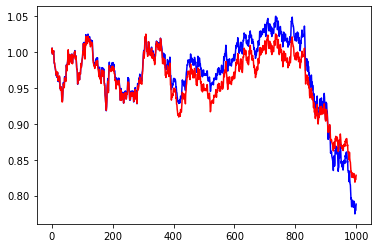

In [54]:
m=1000
DW1=np.random.randn(10**4,m)*np.sqrt(T/m)

Y=Heston_Euler_Scheme(x,DW1,r,sigma,T,m)
X=BS_Explicit(x,DW1,r,sigma,T,m)
              
plt.plot(Y[1,:],color="blue")
plt.plot(X[1,:],color="red")
        

### European Call with Heston model and Euler Scheme

In [55]:
eps=0.001
N0=10**4
M=4

# Multilevel Monte Carlo estimator with Euler Scheme for Euro Call
BS_Scheme=Heston_Euler_Scheme
Payoff=Payoff_Euro_Call



t1_MLMC_Euler=time()
NL_Euler,P_MLMC_Euler,S_Vl,cost,L=MLMC(eps,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
t2_MLMC_Euler=time()

MSE_MLMC_Euler=S_Vl+(P_MLMC_Euler-Call_BS(r,sigma,x,K,T))**2
Weak_Error_squared_MLMC_Euler=(P_MLMC_Euler-Call_BS(r,sigma,x,K,T))**2

print("Weak_Error_squared MLMC Euler=",Weak_Error_squared_MLMC_Euler)
print("MSE MLMC Euler=", MSE_MLMC_Euler,"\n")

print("time=",t2_MLMC_Euler-t1_MLMC_Euler,"\n")

Estimator= 0.10527543740756411
Condidence interval 95%: [0.10434505725682129, 0.10620581755830692]
Error: 0.883758048081942 % 

Computational Cost= 158570.0
Number of samples NL= [66885.  5001.  3334.]
L= 2
eps= 0.001
Weak_Error_squared MLMC Euler= 5.922867546452559e-07
MSE MLMC Euler= 1.0872152639541059e-06 

time= 0.13577008247375488 



# VI. Illustration of the numerical results

The following functions will help us for plots.

In [21]:
def calcul_varmean_Pl(N,M,Payoff,BS_Scheme,r,sigma,T,K):
    VL=np.zeros(L+1)
    ml=np.zeros(L+1)
    for l in range(0,L+1):
        h=T/(M**l)
        DW=np.random.randn(N,M**l)*np.sqrt(h)
        Xbar=BS_Scheme(x,DW,r,sigma,T,M**l)
        VL[l]=np.var(Payoff(Xbar,K,T,r))
        ml[l]=abs(np.mean(Payoff(Xbar,K,T,r)))
    return VL,ml
    

def Calcul_Varmean_Pl1(NL,M,x,BS_Scheme,Payoff,r,sigma,T,K): 
    VL_1=np.zeros(L+1)
    mL_1=np.zeros(L+1)
    DW_L=np.random.randn(NL,1)*np.sqrt(T/1)
    Sbar_L=BS_Scheme(x,DW_L,r,sigma,T,1)
    for l in range(1,L+1):
        DW_L=np.random.randn(NL,M**l)*np.sqrt(T/M**l)
        DW_L_1=np.zeros((NL,int(M**(l-1))))
        for j in range(int(M**(l-1))):
            DW_L_1[:,j]=np.sum(DW_L[:,j*M:(j+1)*M],axis=1)   
        Sbar_L=BS_Scheme(x,DW_L,r,sigma,T,M**l)
        Sbar_L_1=BS_Scheme(x,DW_L_1,r,sigma,T,int(M**(l-1)))
        VL_1[l]=np.var(Payoff(Sbar_L,K,T,r) - Payoff(Sbar_L_1,K,T,r))#var pl-pl-1
        mL_1[l]=abs(np.mean(Payoff(Sbar_L,K,T,r)-Payoff(Sbar_L_1,K,T,r)))
    return (VL_1[1:],mL_1[1:])

## 1. European Call Option

#### Black-Scholes and Euler discretisation

Please run the two following cells to see our global numerical results for the European Call option, with the Black-Scholes model.

In [57]:
BS_Scheme=BS_Euler_Scheme
Payoff=Payoff_Euro_Call
L=4
M=4
NL=10**4
r,sigma,x,K,T=0.05,0.2,1,1,1

l=np.arange(0,L+1)
l1=np.arange(1,L+1)
VL,ml=calcul_varmean_Pl(NL,M,Payoff,BS_Scheme,r,sigma,T,K)
VL_1,mL_1=Calcul_Varmean_Pl1(NL,M,x,BS_Scheme,Payoff,r,sigma,T,K)


eps=[0.001,0.0005,0.0002,0.0001,0.00005]

NLtest1,Ptest,S_Vl,cost1,L1=MLMC(0.001,NL,M,x,BS_Scheme,Payoff,r,sigma,T,K)
NLtest2,Ptest,S_Vl,cost2,L2=MLMC(0.0005,NL,M,x,BS_Scheme,Payoff,r,sigma,T,K)
NLtest3,Ptest,S_Vl,cost3,L3=MLMC(0.0002,NL,M,x,BS_Scheme,Payoff,r,sigma,T,K)
NLtest4,Ptest,S_Vl,cost4,L4=MLMC(0.0001,NL,M,x,BS_Scheme,Payoff,r,sigma,T,K)
NLtest5,Ptest,S_Vl,cost5,L5=MLMC(0.00005,NL,M,x,BS_Scheme,Payoff,r,sigma,T,K)

l_1=np.arange(L1+1)
l_2=np.arange(L2+1)
l_3=np.arange(L3+1)
l_4=np.arange(L4+1)
l_5=np.arange(L5+1)

Estimator= 0.10528691936566985
Condidence interval 95%: [0.10425026209670069, 0.10632357663463901]
Error: 0.9846021473653088 % 

Computational Cost= 98789.0
Number of samples NL= [53749.  4568.  1110.]
L= 2
eps= 0.001
Estimator= 0.10451390107451844
Condidence interval 95%: [0.10398994605317718, 0.1050378560958597]
Error: 0.5013256762539877 % 

Computational Cost= 380064.0
Number of samples NL= [211119.  17473.   4079.]
L= 2
eps= 0.0005
Estimator= 0.10445553124994746
Condidence interval 95%: [0.10426581365257825, 0.10464524884731666]
Error: 0.18162522855322813 % 

Computational Cost= 3768588.0
Number of samples NL= [1610248.  134152.   41915.    8116.]
L= 3
eps= 0.0002
Estimator= 0.10444854778801112
Condidence interval 95%: [0.104360516940231, 0.10453657863579123]
Error: 0.0842815430605954 % 

Computational Cost= 19911531.0
Number of samples NL= [7450976.  618207.  152152.   40537.    9636.]
L= 4
eps= 0.0001
Estimator= 0.10444532353794307
Condidence interval 95%: [0.10440420116887009, 0

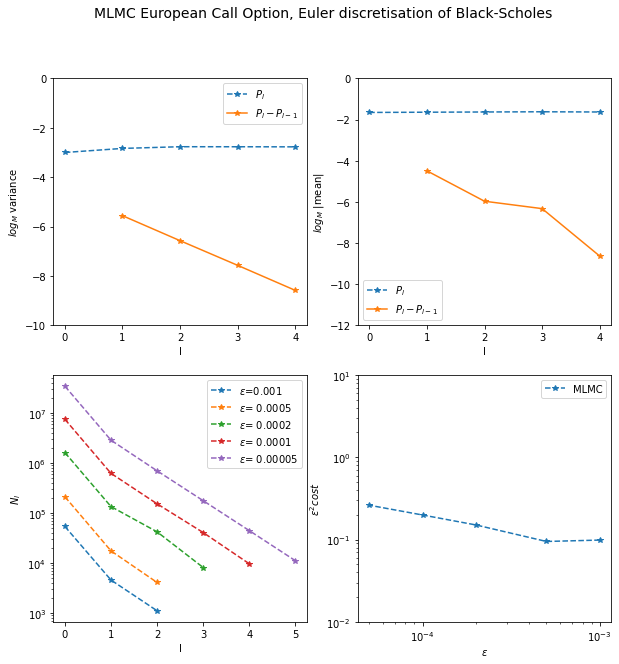

In [58]:
L=4
l=np.arange(0,L+1)
eps=np.array([0.001,0.0005,0.0002,0.0001,0.00005])
cost=np.array([cost1,cost2,cost3,cost4,cost5])



fig,axs=plt.subplots(2,2,figsize=(10,10))

fig = plt.gcf()
fig.suptitle("MLMC European Call Option, Euler discretisation of Black-Scholes", fontsize=14)

axs[0,0].plot(l,np.log(VL)/np.log(M),'*--',label= r'$P_l$')
axs[0,0].plot(l1,np.log(VL_1)/np.log(M),'*-',label="$P_l - P_{l-1}$")
axs[0,0].set_ylabel(r'$log_M$ variance')
axs[0,0].set_xlabel(r'l')
axs[0,0].set_ylim(-10,0)
axs[0,0].legend()

axs[0,1].plot(l,np.log(ml)/np.log(M),'*--',label= r'$P_l$')
axs[0,1].plot(l1,np.log(mL_1)/np.log(M),'*-',label="$P_l - P_{l-1}$")
axs[0,1].set_ylabel(r'$log_M$ |mean|')
axs[0,1].set_xlabel(r'l')
axs[0,1].set_ylim(-12,0)
axs[0,1].legend()

axs[1,0].plot(l_1,NLtest1,'*--',label= f'$\epsilon$=0.001')
axs[1,0].plot(l_2,NLtest2,'*--',label= f'$\epsilon$= 0.0005')
axs[1,0].plot(l_3,NLtest3,'*--',label= f'$\epsilon$= 0.0002')
axs[1,0].plot(l_4,NLtest4,'*--',label= f'$\epsilon$= 0.0001')
axs[1,0].plot(l_5,NLtest5,'*--',label= f'$\epsilon$= 0.00005')
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel(r'$N_l$')
axs[1,0].set_xlabel(r'l')
axs[1,0].legend()

axs[1,1].plot(eps,cost*eps**2,'*--',label='MLMC')

axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1,1].set_ylabel(r'$\epsilon^{2}cost$')
axs[1,1].set_xlabel(r'$\epsilon$')
axs[1,1].set_ylim(0.01,10)
axs[1,1].legend()



## 2. Lookback Option

Please run the two following cells to see our global numerical results for the Lookback option.

In [24]:
BS_Scheme=BS_Euler_Scheme
Payoff=Payoff_Lookback_Option
L=4
M=4
NL=10**4 
r,sigma,x,K,T=0.05,0.2,1,1,1

l=np.arange(0,L+1)
l1=np.arange(1,L+1)
VL,ml=calcul_varmean_Pl(NL,M,Payoff,BS_Scheme,r,sigma,T,K)
VL_1,mL_1=Calcul_Varmean_Pl1(NL,M,x,BS_Scheme,Payoff,r,sigma,T,K)

eps=[0.001,0.0005,0.0002,0.0001]
NLtest1,Ptest,S_Vl,cost1,L1=MLMC(0.001,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
NLtest2,Ptest,S_Vl,cost2,L2=MLMC(0.0005,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
NLtest3,Ptest,S_Vl,cost3,L3=MLMC(0.0002,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
NLtest4,Ptest,S_Vl,cost4,L4=MLMC(0.0001,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)

l_1=np.arange(L1+1)
l_2=np.arange(L2+1)
l_3=np.arange(L3+1)
l_4=np.arange(L4+1)

Estimator= 0.17444432541886187
Condidence interval 95%: [0.17357434689081583, 0.17531430394690792]
Error: 0.4987141461650451 % 

Computational Cost= 208105.0
Number of samples NL= [76555. 11538.  3693.]
L= 2
eps= 0.001
Estimator= 0.17184213852349278
Condidence interval 95%: [0.1715307987816074, 0.17215347826537816]
Error: 0.18117776266082833 % 

Computational Cost= 3538469.0
Number of samples NL= [6.39879e+05 9.15420e+04 2.67560e+04 7.15400e+03 1.82700e+03 5.85000e+02]
L= 5
eps= 0.0005
Estimator= 0.17231733376350855
Condidence interval 95%: [0.17219165014565915, 0.17244301738135795]
Error: 0.07293730416111285 % 

Computational Cost= 21073518.0
Number of samples NL= [3.875253e+06 5.616930e+05 1.647780e+05 4.452200e+04 1.158700e+04
 2.988000e+03]
L= 5
eps= 0.0002
Estimator= 0.17223995631401645
Condidence interval 95%: [0.17218185657982663, 0.17229805604820628]
Error: 0.03373185608796802 % 

Computational Cost= 116286448.0
Number of samples NL= [1.8171173e+07 2.6305790e+06 7.6882700e+05 2

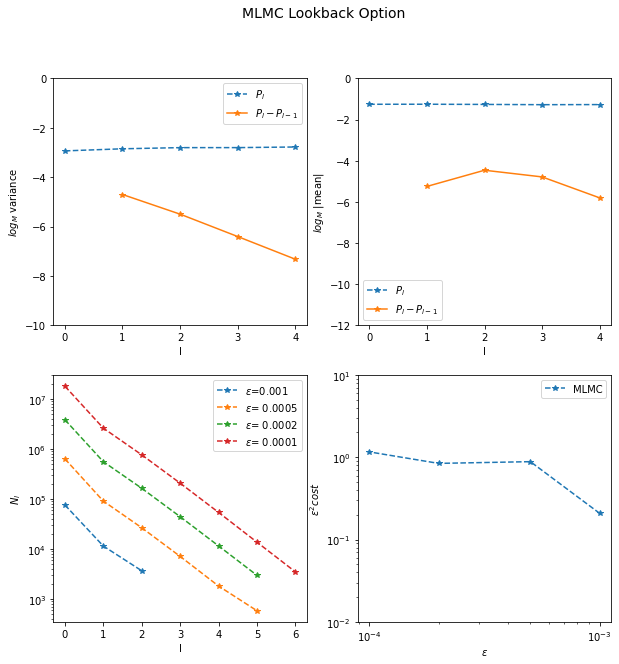

In [25]:
L=4
l=np.arange(0,L+1)
eps=np.array([0.001,0.0005,0.0002,0.0001])
cost=np.array([cost1,cost2,cost3,cost4])

fig,axs=plt.subplots(2,2,figsize=(10,10))

fig = plt.gcf()
fig.suptitle("MLMC Lookback Option", fontsize=14)

axs[0,0].plot(l,np.log(VL)/np.log(M),'*--',label= r'$P_l$')
axs[0,0].plot(l1,np.log(VL_1)/np.log(M),'*-',label="$P_l - P_{l-1}$")
axs[0,0].set_ylabel(r'$log_M$ variance')
axs[0,0].set_xlabel(r'l')
axs[0,0].set_ylim(-10,0)
axs[0,0].legend()

axs[0,1].plot(l,np.log(ml)/np.log(M),'*--',label= r'$P_l$')
axs[0,1].plot(l1,np.log(mL_1)/np.log(M),'*-',label="$P_l - P_{l-1}$")
axs[0,1].set_ylabel(r'$log_M$ |mean|')
axs[0,1].set_xlabel(r'l')
axs[0,1].set_ylim(-12,0)
axs[0,1].legend()

axs[1,0].plot(l_1,NLtest1,'*--',label= f'$\epsilon$=0.001')
axs[1,0].plot(l_2,NLtest2,'*--',label= f'$\epsilon$= 0.0005')
axs[1,0].plot(l_3,NLtest3,'*--',label= f'$\epsilon$= 0.0002')
axs[1,0].plot(l_4,NLtest4,'*--',label= f'$\epsilon$= 0.0001')
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel(r'$N_l$')
axs[1,0].set_xlabel(r'l')
axs[1,0].legend()

axs[1,1].plot(eps,cost*eps**2,'*--',label='MLMC')

axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1,1].set_ylabel(r'$\epsilon^{2}cost$')
axs[1,1].set_xlabel(r'$\epsilon$')
axs[1,1].set_ylim(0.01,10)
axs[1,1].legend()

## 3. Digital Option

Please run the two following cells to see our global numerical results for the Digital option.

In [48]:
BS_Scheme=BS_Euler_Scheme
Payoff=Payoff_Digital_Option
L=4
M=4
NL=10**4 #Extra Samples
r,sigma,x,K,T=0.05,0.2,1,1,1

l=np.arange(0,L+1)
l1=np.arange(1,L+1)
VL,ml=calcul_varmean_Pl(NL,M,Payoff,BS_Scheme,r,sigma,T,K)
VL_1,mL_1=Calcul_Varmean_Pl1(NL,M,x,BS_Scheme,Payoff,r,sigma,T,K)

N0=10**4
eps=[0.005,0.002,0.001,0.0005]
NLtest1,Ptest,S_Vl,cost1,L1=MLMC(0.005,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
NLtest2,Ptest,S_Vl,cost2,L2=MLMC(0.002,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
NLtest3,Ptest,S_Vl,cost3,L3=MLMC(0.001,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)
NLtest4,Ptest,S_Vl,cost4,L4=MLMC(0.0005,N0,M,x,BS_Scheme,Payoff,r,sigma,T,K)

l_1=np.arange(L1+1)
l_2=np.arange(L2+1)
l_3=np.arange(L3+1)
l_4=np.arange(L4+1)


Estimator= 0.5429041603186707
Condidence interval 95%: [0.537809413438531, 0.5479989071988105]
Error: 0.9384247262259457 % 

Computational Cost= 60296.0
Number of samples NL= [30431.  5573.   100.]
L= 2
eps= 0.005
Estimator= 0.5328322131813861
Condidence interval 95%: [0.5316294816620177, 0.5340349447007544]
Error: 0.22572425045160707 % 

Computational Cost= 3442340.0
Number of samples NL= [5.55385e+05 9.67150e+04 3.86250e+04 1.99860e+04 1.00000e+02]
L= 4
eps= 0.002
Estimator= 0.5230177964733486
Condidence interval 95%: [0.5220592998640612, 0.5239762930826359]
Error: 0.18326271414670878 % 

Computational Cost= 1809076.0
Number of samples NL= [8.25941e+05 1.88227e+05 1.00000e+02 1.00000e+02 1.00000e+02]
L= 4
eps= 0.001
Estimator= 0.5325030877988556
Condidence interval 95%: [0.5322551786007167, 0.5327509969969945]
Error: 0.04655544800006294 % 

Computational Cost= 124704056.0
Number of samples NL= [13320861.  2297319.   915586.   339075.   170184.]
L= 4
eps= 0.0005


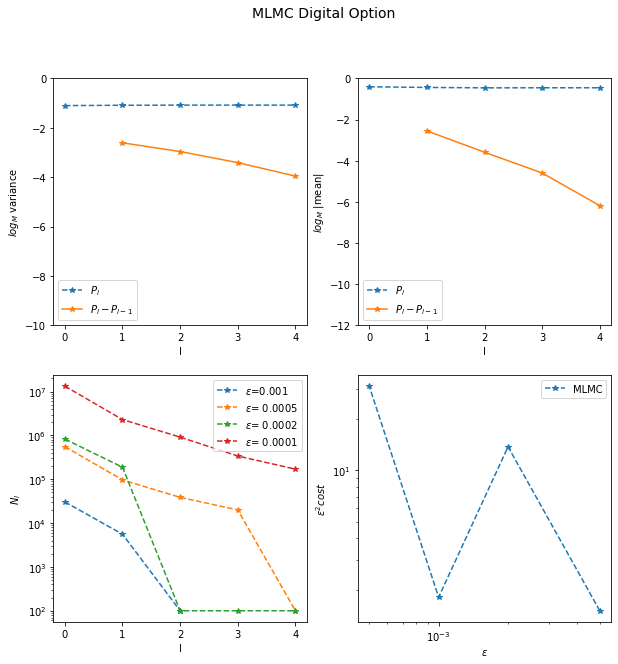

In [49]:


L=4
l=np.arange(0,L+1)
eps=np.array([0.005,0.002,0.001,0.0005])
cost=np.array([cost1,cost2,cost3,cost4])

fig,axs=plt.subplots(2,2,figsize=(10,10))

fig.suptitle("MLMC Digital Option", fontsize=14)

axs[0,0].plot(l,np.log(VL)/np.log(M),'*--',label= r'$P_l$')
axs[0,0].plot(l1,np.log(VL_1)/np.log(M),'*-',label="$P_l - P_{l-1}$")
axs[0,0].set_ylabel(r'$log_M$ variance')
axs[0,0].set_xlabel(r'l')
axs[0,0].set_ylim(-10,0)
axs[0,0].legend()

axs[0,1].plot(l,np.log(ml)/np.log(M),'*--',label= r'$P_l$')
axs[0,1].plot(l1,np.log(mL_1)/np.log(M),'*-',label="$P_l - P_{l-1}$")
axs[0,1].set_ylabel(r'$log_M$ |mean|')
axs[0,1].set_xlabel(r'l')
axs[0,1].set_ylim(-12,0)
axs[0,1].legend()

axs[1,0].plot(l_1,NLtest1,'*--',label= f'$\epsilon$=0.001')
axs[1,0].plot(l_2,NLtest2,'*--',label= f'$\epsilon$= 0.0005')
axs[1,0].plot(l_3,NLtest3,'*--',label= f'$\epsilon$= 0.0002')
axs[1,0].plot(l_4,NLtest4,'*--',label= f'$\epsilon$= 0.0001')
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel(r'$N_l$')
axs[1,0].set_xlabel(r'l')
axs[1,0].legend()

axs[1,1].plot(eps,cost*eps**2,'*--',label='MLMC')

axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1,1].set_ylabel(r'$\epsilon^{2}cost$')
axs[1,1].set_xlabel(r'$\epsilon$')

axs[1,1].legend()